In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from scipy import special
from scipy.stats import skewnorm, norm#, expon, exponnorm
from scipy.integrate import quad

In [2]:
h = 6.582e-16 # эВ·c
kT = 0.025
ieV = 1e-12/h
ieV

1519.2950470981464

In [3]:
def multichoose(n,k):
    if k < 0 or n < 0: return "Error"
    if not k: return [[0]*n]
    if not n: return []
    if n == 1: return [[k]]
    return [[0]+val for val in multichoose(n-1,k)] + \
        [[val[0]+1]+val[1:] for val in multichoose(n,k-1)]

In [4]:
multichoose(4,2) # terms, degree

[[0, 0, 0, 2],
 [0, 0, 1, 1],
 [0, 0, 2, 0],
 [0, 1, 0, 1],
 [0, 1, 1, 0],
 [0, 2, 0, 0],
 [1, 0, 0, 1],
 [1, 0, 1, 0],
 [1, 1, 0, 0],
 [2, 0, 0, 0]]

In [5]:
pers = [ multichoose(4,n) for n in range(4) ] # permutations

In [6]:
len(pers[-1])

20

In [7]:
pers[1]

[[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0]]

```python
solver(
    t_last = 3, # время по оси абцисс
    tau_e = 0.05, tau_p = 0.05, tau_1 = 1, tau_2 = 2, 
    # времена: накачки (excitation), стробирования (probe), 
    # гаусовой и передемпфированой "дебаевской" мод
    gamma = 2e-3, omega_r = 0.01, # параметры броуновской моды
    h_w_e = 3, delta_G = -2.5, Er = 0.2, kBT = 0.025, # энергетические параметры
    w1 = 0.3, w2 = 0.3, w3 = 0.4 # веса 
)```

In [8]:
def solver(
    t_last = 3,
    tau_e = 0.05, tau_p = 0.05, tau_1 = 1, tau_2 = 2, gamma = 2e-3, omega_r = 0.01, 
    h_w_e = 3, delta_G = -2.5, Er = 0.2, kBT = 0.025, w1 = 0.3, w2 = 0.3, w3 = 0.4 ):
    
    t = np.linspace(0, t_last, 128) # np.arange(0, t_last, 0.01)
    tau_1 *= ieV; tau_2 *= ieV; tau_e *= ieV; tau_p *= ieV; t *= ieV 
    E = delta_G + Er
    eps = 4*Er*kBT
    U = h_w_e + delta_G - Er
    omega = np.sqrt(omega_r**2-0.25*gamma**2)
    g = 0.5*gamma/omega
    nup = 1 / np.sqrt(2) / tau_p
    nue = np.sqrt(2) / tau_e
    nupe = np.sqrt(nue**2 + nup**2)
    kappa = eps*tau_e**2 / (2 + eps*tau_e**2)
    W = 2*Er + kappa*U
    q20 = E**2 + 0.5*eps
    q21 = -2*E*W
    q22 = W**2 - 0.5*eps*kappa
    q30 = -E*(E**2 + 1.5*eps)
    q31 = 3*W*q20
    q32 = -3*E*q22
    q33 = W*(W**2 - 1.5*eps*kappa)
    
    def f(N, k, l, m, n):
        nud = 0.5*gamma*(m+n) + l/tau_2 + 1j*omega*(m-n)
        w_N = w1**k * w2**l * (0.5*w3)**(m+n) * (1+1j*g)**m * (1-1j*g)**n
        nug = np.sqrt(k)/tau_1
        nuge = np.sqrt(nug**2 + nue**2)
        nuo = nug*nue/nuge
        nupo = np.sqrt(nup**2 + nuo**2)
        a3 = nup*nue/(nuge*nupo)
        c3 = 0.5*nud/nuge
        c4 = nue**2 / (nupo*nuge)
        c5 = c3**2 * (c4**2 + 1)
        ee = -a3**2*( (nug*t)**2 + nud*t ) + c5
        er = (nud*nupe**2 - 2*t*nup**2*nue**2) / (2*nuge*nupo*nupe)
        anso = np.real( w_N * np.exp(ee) * special.erfc(er))  * (nue/nuge) * (nup/nupo)
        koef = factorial(N) / ( factorial(k) * factorial(l) * factorial(m) * factorial(n) )
        return (koef * anso)
    
    def phi(p):
        res = np.zeros(len(t))
        for p_i in p:
            k,l,m,n = p_i
            N = k+l+m+n
            res += np.real( f(N, k,l,m,n) )
        return res
    
    Ps = [ phi(p) for p in pers ]
    F0 = Ps[0]
    F1 =  -E*Ps[0] + W*Ps[1]
    F2 = q20*Ps[0] + q21*Ps[1] + q22*Ps[2]
    F3 = q30*Ps[0] + q31*Ps[1] + q32*Ps[2] + q33*Ps[3]
    m1 = F1/F0
    m2 = F2/F0 - m1**2
    m3 = F3/F0 - 3*m1*m2 - m1**3
    return t/ieV, m1, m2, m3

In [9]:
Ts, M1s, M2s, M3s = solver()

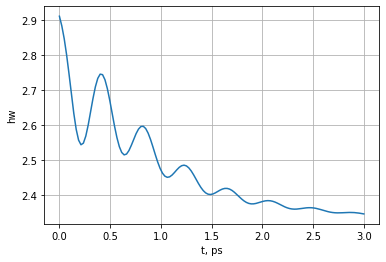

In [10]:
plt.figure()
plt.plot(Ts, M1s)
plt.xlabel('t, ps')
plt.ylabel('hw')
plt.grid(True)
plt.show()

In [11]:
newParams = {'figure.figsize'  : (12, 4),  # Figure size
             'figure.dpi'      : 200,      # figure resolution
             'axes.titlesize'  : 18,       # fontsize of title
             'axes.labelsize'  : 12,       # fontsize of axes labels
             'axes.linewidth'  : 1,        # width of the figure box lines
             'lines.linewidth' : 2,        # width of the plotted lines
             'savefig.dpi'     : 200,      # resolution of a figured saved using plt.savefig(filename)
             'ytick.labelsize' : 12,       # fontsize of tick labels on y axis
             'xtick.labelsize' : 12,       # fontsize of tick labels on x axis
             'legend.fontsize' : 14,       # fontsize of labels in legend
             'legend.title_fontsize' : 12,       # fontsize of labels in legend
             'legend.frameon'  : True,     # activate frame on lengend?
            }
plt.rcParams.update(newParams) # Set new plotting parameters

In [12]:
def plotter(x, a, b, c, labs, titol, ylab):
    plt.plot(x, a, label = labs[0])
    plt.plot(x, b, label = labs[1])
    plt.plot(x, c, label = labs[2])
    plt.title(titol)
    plt.xlabel('t, пс')
    plt.ylabel(ylab)
    plt.legend()
    plt.grid(True)

# W_i

In [13]:
Ts, M1s_a, M2s_a, M3s_a = solver(w1 = 1.0, w2 = 0.0, w3 = 0.0)
Ts, M1s_b, M2s_b, M3s_b = solver(w1 = 0.0, w2 = 1.0, w3 = 0.0)
Ts, M1s_c, M2s_c, M3s_c = solver(w1 = 0.0, w2 = 0.0, w3 = 1.0)

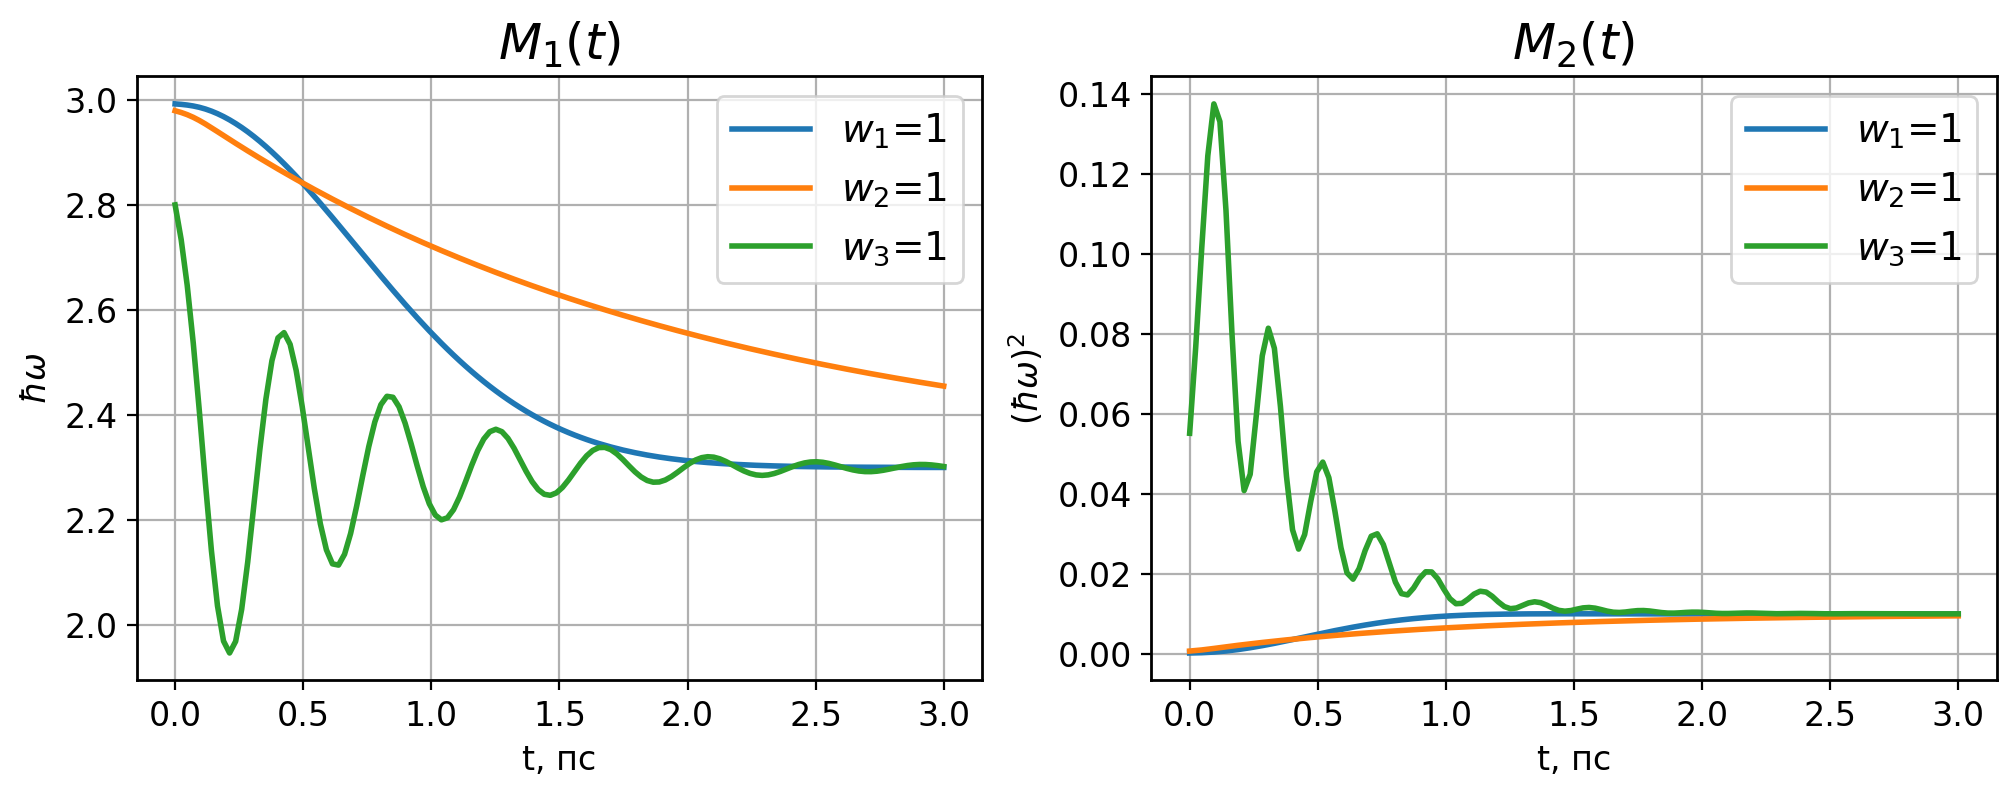

In [14]:
# Create subplot indexed 1 in a figure with a grid of 1 rows 2 columns.
plt.subplot(121)
plotter(Ts, M1s_a, M1s_b, M1s_c, ['$w_1$=1', '$w_2$=1', '$w_3$=1'],  
        '$M_1(t)$', '$\\hbar\\omega$')
plt.subplot(122)
plotter(Ts, M2s_a, M2s_b, M2s_c, ['$w_1$=1', '$w_2$=1', '$w_3$=1'],  
        '$M_2(t)$', '$(\\hbar\\omega)^2$')
plt.savefig('w_eq_1.png')
plt.show()

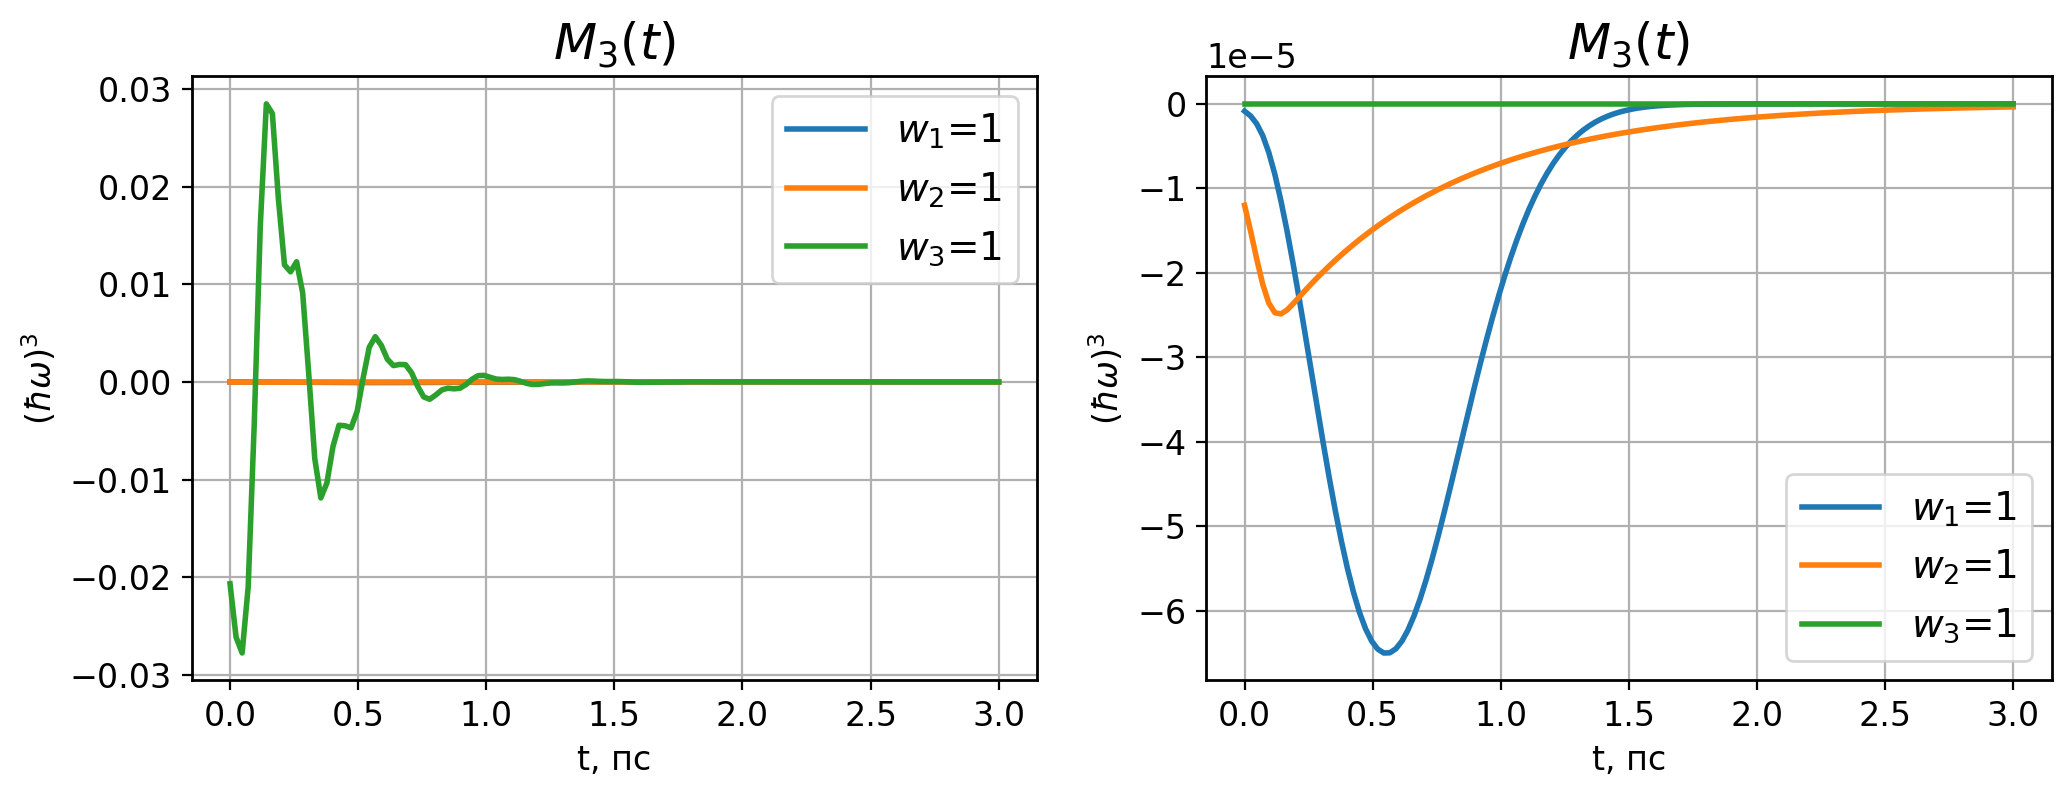

In [16]:
# Create subplot indexed 1 in a figure with a grid of 1 rows 2 columns.
plt.subplot(121)
plotter(Ts, M3s_a, M3s_b, M3s_c, ['$w_1$=1', '$w_2$=1', '$w_3$=1'],  
        '$M_3(t)$', '$(\\hbar\\omega)^3$')
plt.subplot(122)
plotter(Ts, M3s_a, M3s_b, np.zeros(len(Ts)), ['$w_1$=1', '$w_2$=1', '$w_3$=1'],  
        '$M_3(t)$', '$(\\hbar\\omega)^3$')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.savefig('w_eq_1_m3.png')
plt.show()

# tau_p

In [17]:
Ts, M1s_a, M2s_a, M3s_a = solver(tau_p = 0.05)
Ts, M1s_b, M2s_b, M3s_b = solver(tau_p = 0.1)
Ts, M1s_c, M2s_c, M3s_c = solver(tau_p = 0.2)

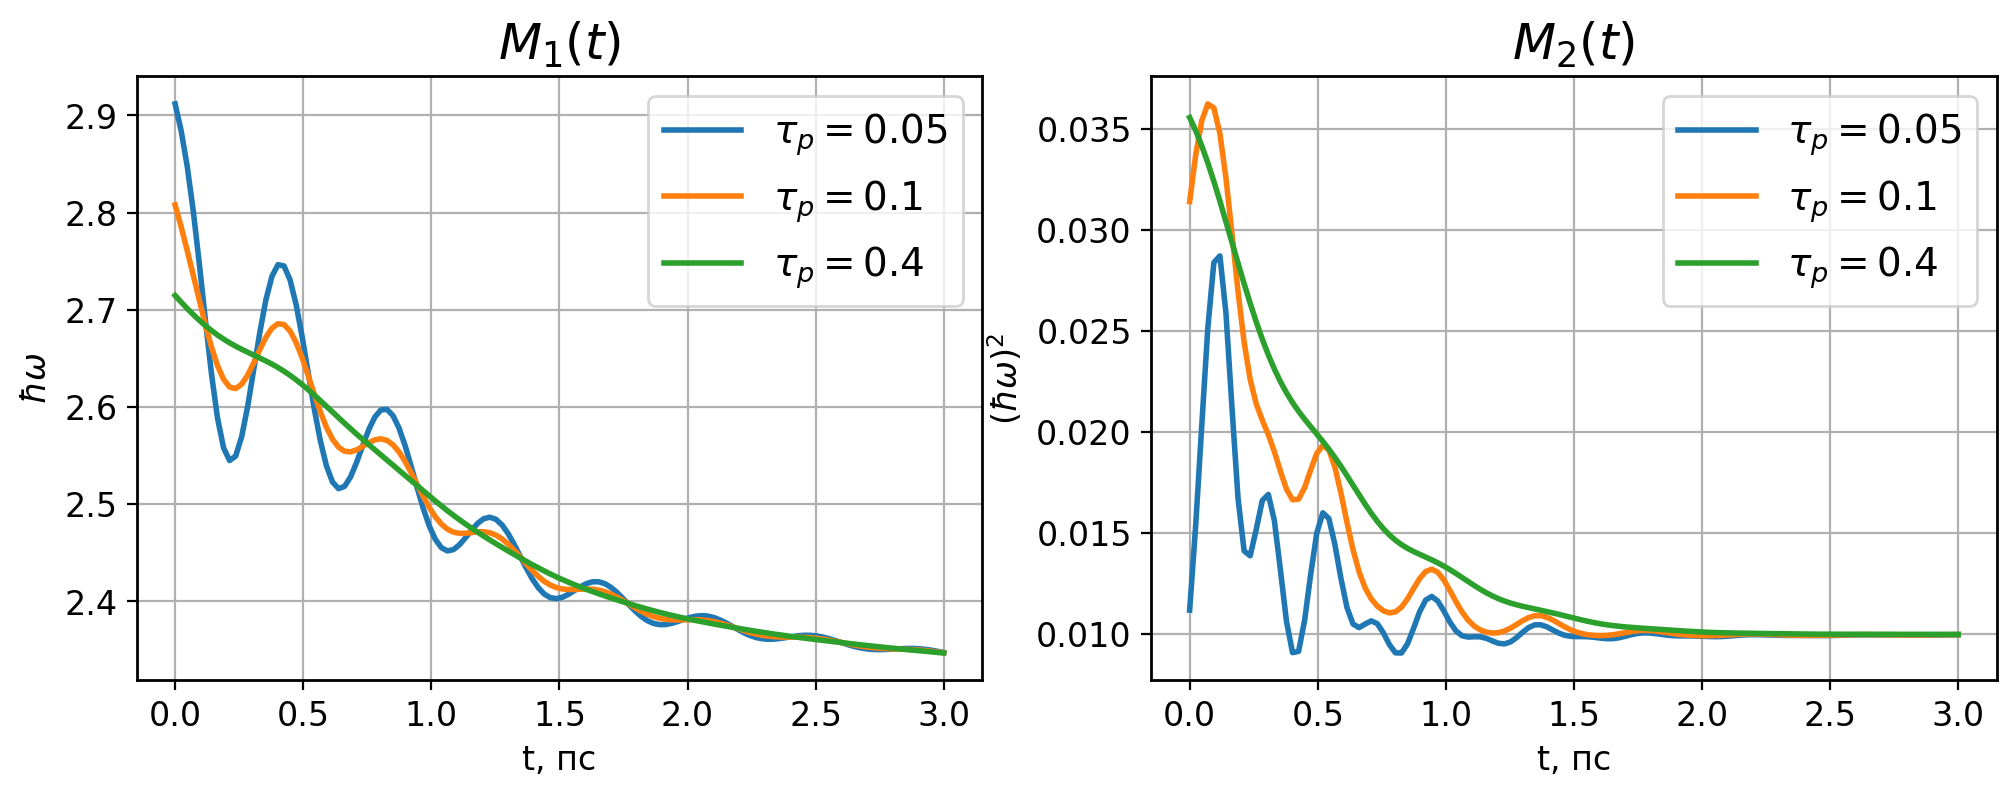

In [18]:
# Create subplot indexed 1 in a figure with a grid of 1 rows 2 columns.
plt.subplot(121)
plotter(Ts, M1s_a, M1s_b, M1s_c, ['$\\tau_p = 0.05$', '$\\tau_p = 0.1$', '$\\tau_p = 0.4$'],  
        '$M_1(t)$', '$\\hbar\\omega$')
plt.subplot(122)
plotter(Ts, M2s_a, M2s_b, M2s_c, ['$\\tau_p = 0.05$', '$\\tau_p = 0.1$', '$\\tau_p = 0.4$'],  
        '$M_2(t)$', '$(\\hbar\\omega)^2$')
plt.savefig('taup.png')
plt.show()

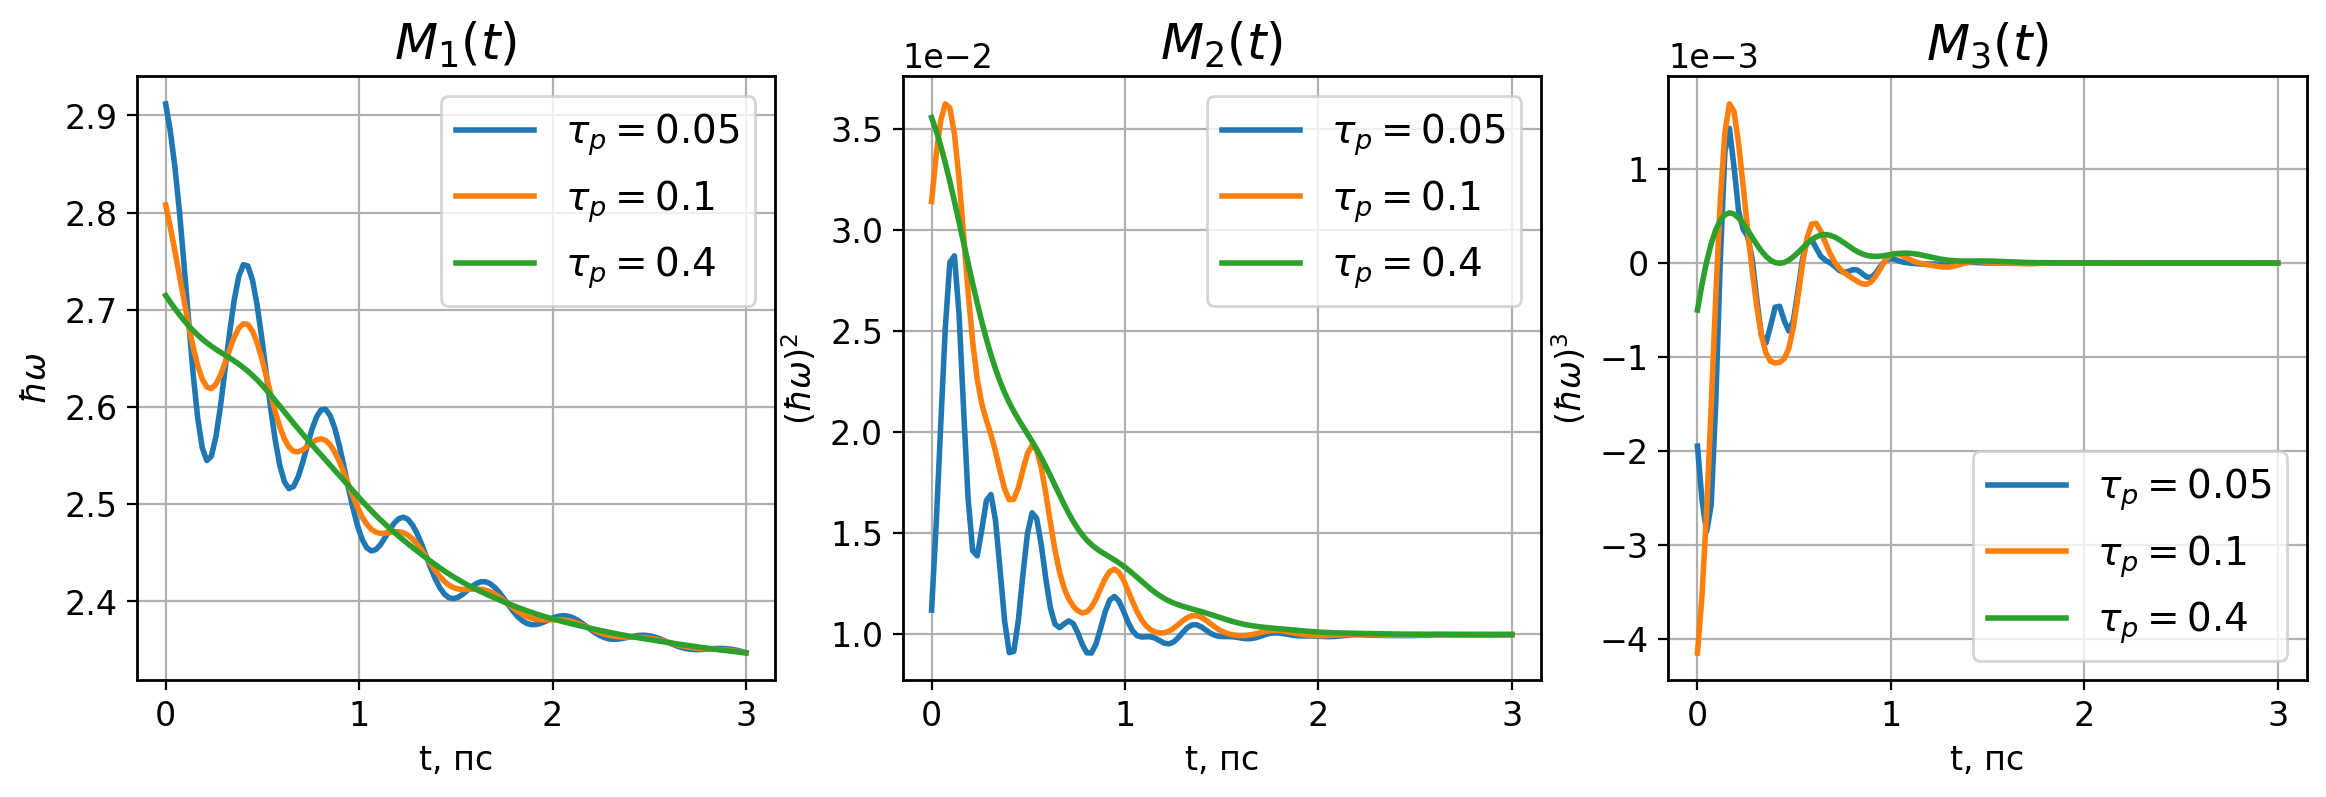

In [20]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plotter(Ts, M1s_a, M1s_b, M1s_c, ['$\\tau_p = 0.05$', '$\\tau_p = 0.1$', '$\\tau_p = 0.4$'],  
        '$M_1(t)$', '$\\hbar\\omega$')
plt.subplot(132)
plotter(Ts, M2s_a, M2s_b, M2s_c, ['$\\tau_p = 0.05$', '$\\tau_p = 0.1$', '$\\tau_p = 0.4$'],  
        '$M_2(t)$', '$(\\hbar\\omega)^2$')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.subplot(133)
plotter(Ts, M3s_a, M3s_b, M3s_c, ['$\\tau_p = 0.05$', '$\\tau_p = 0.1$', '$\\tau_p = 0.4$'],  
        '$M_3(t)$', '$(\\hbar\\omega)^3$')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.savefig('taup3.png')
plt.show()

# W_1

In [21]:
Ts, M1s_a, M2s_a, M3s_a = solver(w1 = 0.3, w2 = 0.3, w3 = 0.4)
Ts, M1s_b, M2s_b, M3s_b = solver(w1 = 0.1, w2 = 0.5, w3 = 0.4)
Ts, M1s_c, M2s_c, M3s_c = solver(w1 = 0.0, w2 = 0.6, w3 = 0.4)

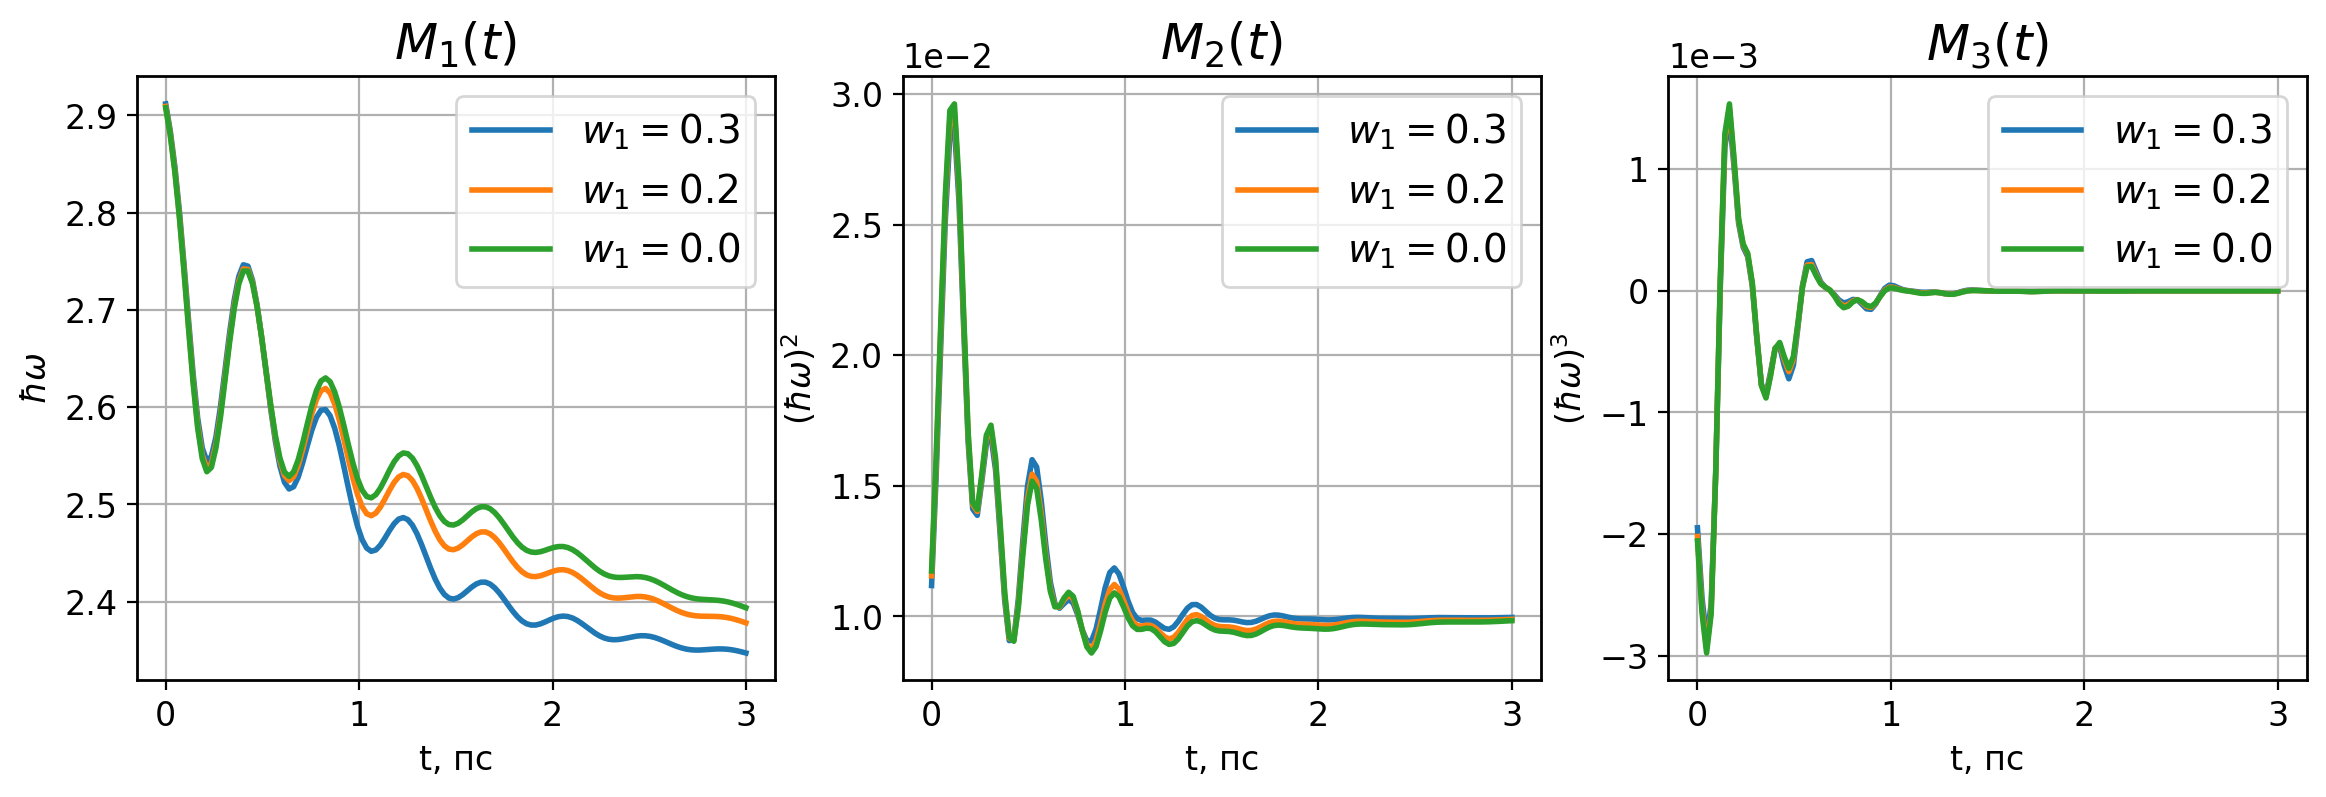

In [22]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plotter(Ts, M1s_a, M1s_b, M1s_c, ['$w_1 = 0.3$', '$w_1 = 0.2$', '$w_1 = 0.0$'],  
        '$M_1(t)$', '$\\hbar\\omega$')
plt.subplot(132)
plotter(Ts, M2s_a, M2s_b, M2s_c, ['$w_1 = 0.3$', '$w_1 = 0.2$', '$w_1 = 0.0$'],  
        '$M_2(t)$', '$(\\hbar\\omega)^2$')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.subplot(133)
plotter(Ts, M3s_a, M3s_b, M3s_c, ['$w_1 = 0.3$', '$w_1 = 0.2$', '$w_1 = 0.0$'],  
        '$M_3(t)$', '$(\\hbar\\omega)^3$')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.savefig('w1.png')
plt.show()

# W_3

In [23]:
Ts, M1s_a, M2s_a, M3s_a = solver(w1 = 0.3, w2 = 0.3, w3 = 0.4)
Ts, M1s_b, M2s_b, M3s_b = solver(w1 = 0.4, w2 = 0.4, w3 = 0.2)
Ts, M1s_c, M2s_c, M3s_c = solver(w1 = 0.5, w2 = 0.5, w3 = 0.0)

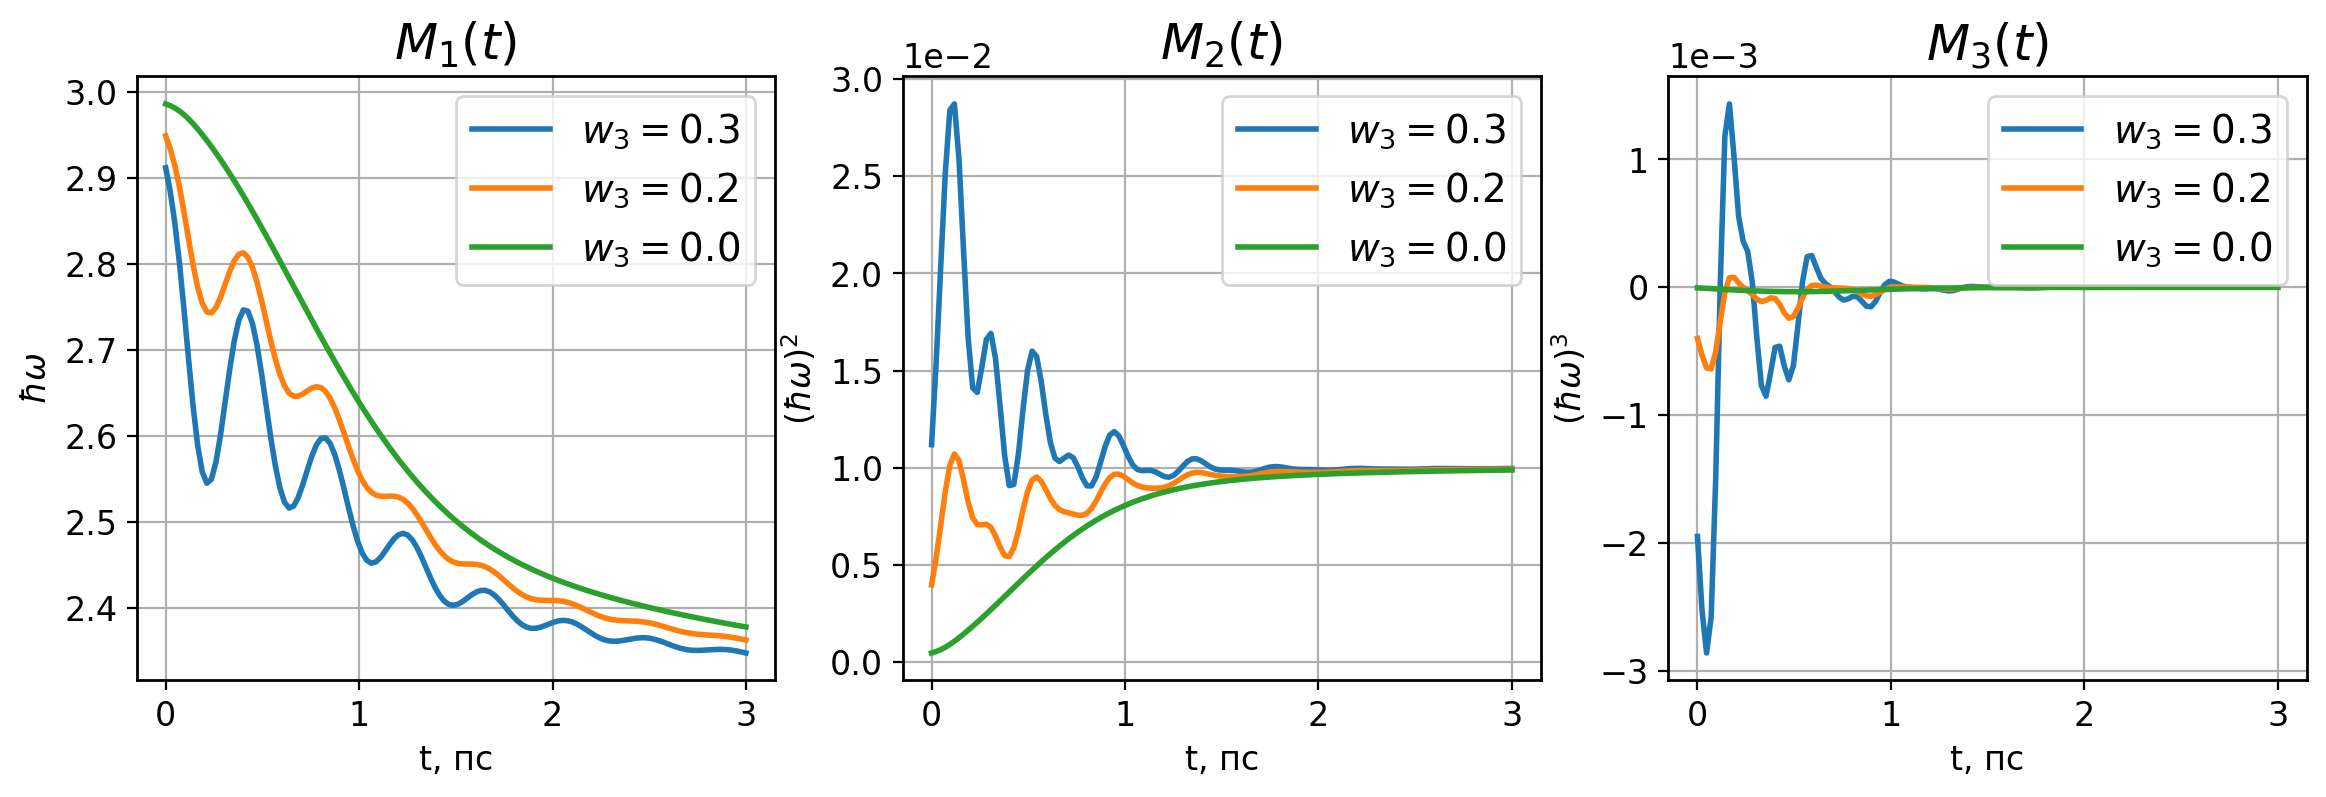

In [24]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plotter(Ts, M1s_a, M1s_b, M1s_c, ['$w_3 = 0.3$', '$w_3 = 0.2$', '$w_3 = 0.0$'],  
        '$M_1(t)$', '$\\hbar\\omega$')
plt.subplot(132)
plotter(Ts, M2s_a, M2s_b, M2s_c, ['$w_3 = 0.3$', '$w_3 = 0.2$', '$w_3 = 0.0$'],  
        '$M_2(t)$', '$(\\hbar\\omega)^2$')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.subplot(133)
plotter(Ts, M3s_a, M3s_b, M3s_c, ['$w_3 = 0.3$', '$w_3 = 0.2$', '$w_3 = 0.0$'],  
        '$M_3(t)$', '$(\\hbar\\omega)^3$')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.savefig('w3.png')
plt.show()

# Inverse problem

In [25]:
def Xres(t, gam = 0.001, Om_r = 0.05):
    if Om_r**2 < 0.25*gam**2:
        Om = np.sqrt( 0.25*gam**2 - Om_r**2 )
        X = np.exp( -0.5*gam*t )*(np.cosh(Om*t) + 0.5*gam/Om*np.sinh(Om*t) )
    else:
        Om = np.sqrt( Om_r**2 - 0.25*gam**2 )
        X = np.exp( -0.5*gam*t )*( np.cos(Om*t) + 0.5*gam/Om*np.sin(Om*t) )
    return X

In [26]:
def calcdyn(Tm, om, dG = -2.5, Er = 0.2, te = 0.05, om_e = 3.0, 
            gam = 2e-3, Om_r = 1e-2, tq = 1.0, td = 2.0, weights = [0.3, 0.3, 0.4] ): 
    b = Er*kT
    te *= ieV; td *= ieV; tq *= ieV; T = Tm*ieV
    Ze = te*np.sqrt( 2*np.pi**2*b/(2*b+te**-2) ) * np.exp( -(om_e + dG - Er)**2 / (4*b + 2/(te**2)) )
    def X(t):
        return weights[0]*np.exp(-(t/tq)**2) + weights[1]*np.exp(-t/td) + weights[2]*Xres(t,gam,Om_r)
    
    def Fi(xi, y1, t):
        Xt = X(t-xi)
        if Xt > 1.0:
            Xt = 1.0
        hw = y1 - 2*Er*Xt
        hdwe = om_e + dG - Er - hw*Xt
        se2 = 2*b*(1 - Xt**2) + te**-2
        return np.exp( -0.25*hw**2/b - 2*(xi/te)**2 - 0.5*hdwe**2/se2 ) / (Zₑ*np.sqrt(se2))
    
    y1 = om + dG + Er
    return [  om**3 * quad( Fi, -8*te, t, args=(y1, t) )[0] for t in T ]

In [27]:
Omin = 2.0
Omax = 3.1
Tspan = np.linspace(0, 3, 128)
Omspan = np.linspace(Omin, Omax, 128);

In [28]:
import time

In [29]:
S0 = np.zeros((len(Omspan),len(Tspan)))
start_time = time.time()  # Начало измерения времени  
for i in range(len(Omspan)):
    ss0 = calcdyn(Tspan, Omspan[i], dG=-2.5, Er=0.2, te=0.05, om_e=3.0, 
                  gam=2e-3, Om_r=1e-2, weights = [0.3, 0.3, 0.4] )
    for j in range(len(Tspan)):
        S0[i,j] = ss0[j]
end_time = time.time()  # Конец измерения времени  
print(f"run time: {end_time - start_time:.2f} seconds")  # Вывод времени в секундах 

run time: 107.32 seconds


In [30]:
for i in range(len(Tspan)): # Нормировка на единицу по площади
    S0[:,i] /= np.trapz(S0[:,i], Omspan)

In [ ]:
# или 
for i in range(len(Tspan)): # Нормировка на единицу по амплитуде
    S0[:,i] /= max(S0[:,i])

In [31]:
M1n = [ np.sum(S0[:,i] * Omspan)/sum(S0[:,i]) for i in range(len(Tspan)) ];

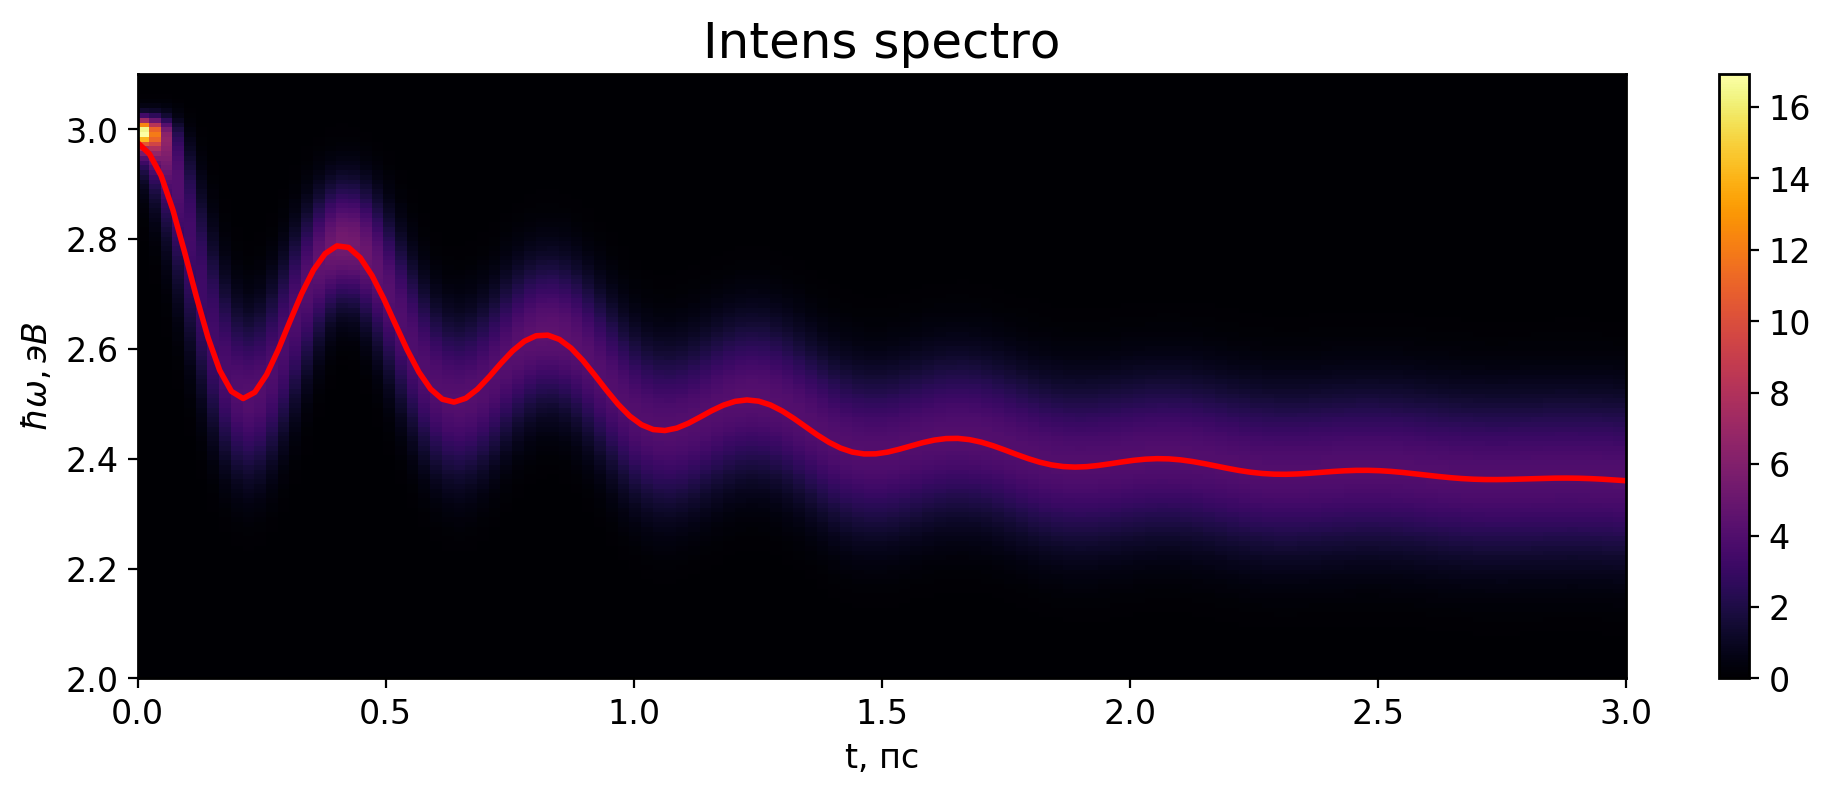

In [32]:
plt.pcolormesh(Tspan, Omspan, S0, cmap = 'inferno')
plt.colorbar()
plt.plot(Tspan, M1n, label = 'M1', color = 'red')
plt.title('Intens spectro')
plt.xlabel('t, пс')
plt.ylabel('$\\hbar\\omega, эВ$')
plt.show()

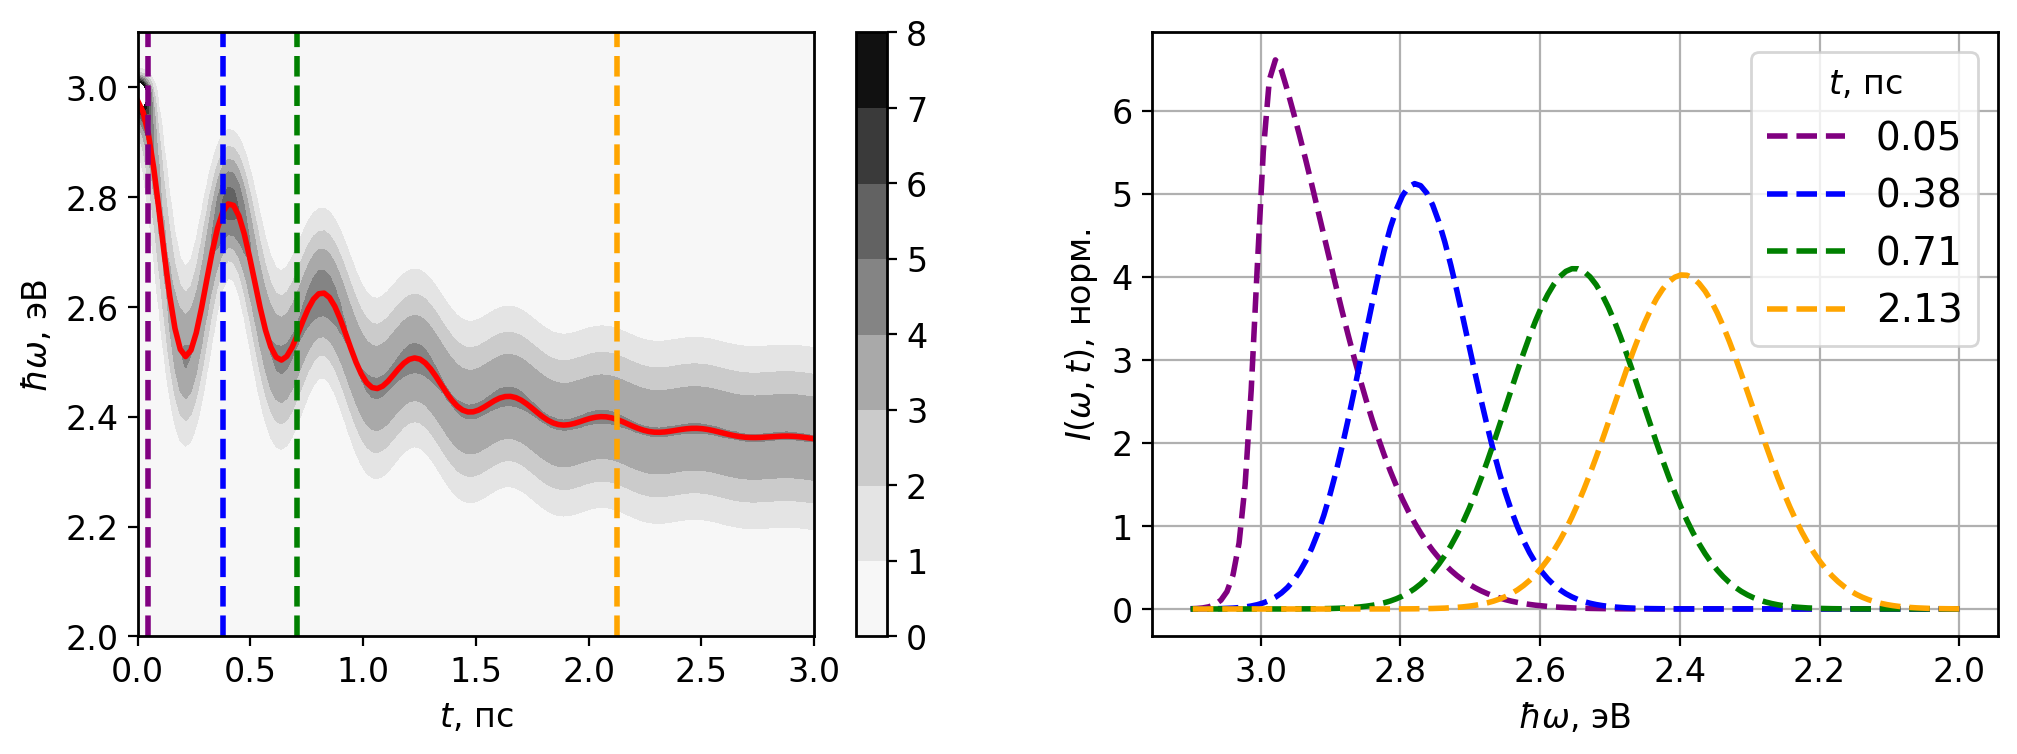

In [33]:
plt.subplot(121)
plt.contourf(Tspan, Omspan, S0, cmap = 'Greys', levels = np.linspace(0.0, 8.0, 9))
#plt.pcolormesh(Tspan, Omspan, S0, cmap = 'Greys')
plt.colorbar()
plt.plot(Tspan, M1n, label = 'M1', color = 'red')
plt.plot([ Tspan[2 ], Tspan[2 ] ], [ Omspan[0], Omspan[-1] ], '--', color = 'purple' )
plt.plot([ Tspan[16], Tspan[16] ], [ Omspan[0], Omspan[-1] ], '--', color = 'blue' )
plt.plot([ Tspan[30], Tspan[30] ], [ Omspan[0], Omspan[-1] ], '--', color = 'green' )
plt.plot([ Tspan[90], Tspan[90] ], [ Omspan[0], Omspan[-1] ], '--', color = 'orange' )
plt.xlabel('$t$, пс')
plt.ylabel('$\\hbar\\omega$, эВ')

plt.subplot(122)#f'Sine Wave (Factor: {value1:.2f})'
plt.plot(Omspan, S0[:,2],  '--', label = f'{Tspan[2 ]:.2f}', color = 'purple' )
plt.plot(Omspan, S0[:,16], '--', label = f'{Tspan[16]:.2f}', color = 'blue' )
plt.plot(Omspan, S0[:,30], '--', label = f'{Tspan[30]:.2f}', color = 'green' )
plt.plot(Omspan, S0[:,90], '--', label = f'{Tspan[90]:.2f}', color = 'orange' )
plt.legend(title='$t$, пс')
plt.ylabel('$I(\\omega,t)$, норм.')
plt.xlabel('$\\hbar\\omega$, эВ')
plt.gca().invert_xaxis()
plt.grid(True)

plt.savefig('spectra_dyn.png')
plt.show()

In [34]:
def normspec(x, y):
    # Нормируем спектральные данные
    y_normalized = y / np.trapz(y, x)
    # Вычисляем моменты распределения
    mean = np.trapz(x * y_normalized, x)
    variance = np.trapz((x - mean)**2 * y_normalized, x)
    std_dev = np.sqrt(variance)
    #return np.exp( -0.5*(x-mean)**2 / variance ) / np.sqrt( 2*np.pi*variance )
    return norm.pdf(x, loc=mean, scale=std_dev)

In [35]:
def skewspec(x, y):
    # Нормируем спектральные данные
    y_normalized = y / np.trapz(y, x)
    # Вычисляем моменты распределения
    mean = np.trapz(x * y_normalized, x)
    variance = np.trapz((x - mean)**2 * y_normalized, x)
    std_dev = np.sqrt(variance)
    skewness = np.trapz((x - mean)**3 * y_normalized, x) / (std_dev**3)
    # Параметры для skewnormal
    st = np.cbrt( 2*skewness/(4-np.pi) )**2
    d2 = 0.5*np.pi*st/(st+1)
    mu = mean - np.sign(skewness) * std_dev*np.sqrt(st) # ? -
    sigma = std_dev*np.sqrt(st+1)
    tau = np.sign(skewness) * np.sqrt( d2/(1-d2) ) # ? +
    #print(skewness)
    return skewnorm.pdf(x, tau, loc=mu, scale=sigma) #* np.sqrt(2*np.pi*variance)

In [47]:
def profile_plotter(timenum, textx, texty, labs):
    y_values = skewspec(Omspan, S0[:,timenum])
    #y_values /= max(y_values)
    gaussian = normspec(Omspan, S0[:,timenum])
    #gaussian /= max(gaussian)
    
    plt.plot(Omspan, S0[:,timenum],  linewidth=3, label=labs[0], color='black')
    plt.plot(Omspan, y_values, '--', linewidth=3, label=labs[1], color='blue')
    plt.plot(Omspan, gaussian,  ':', linewidth=3, label=labs[2], color='red')
    plt.text(x = textx, y = texty, s = f'$t$ = {Tspan[timenum]:.2f} пс', fontsize=14)

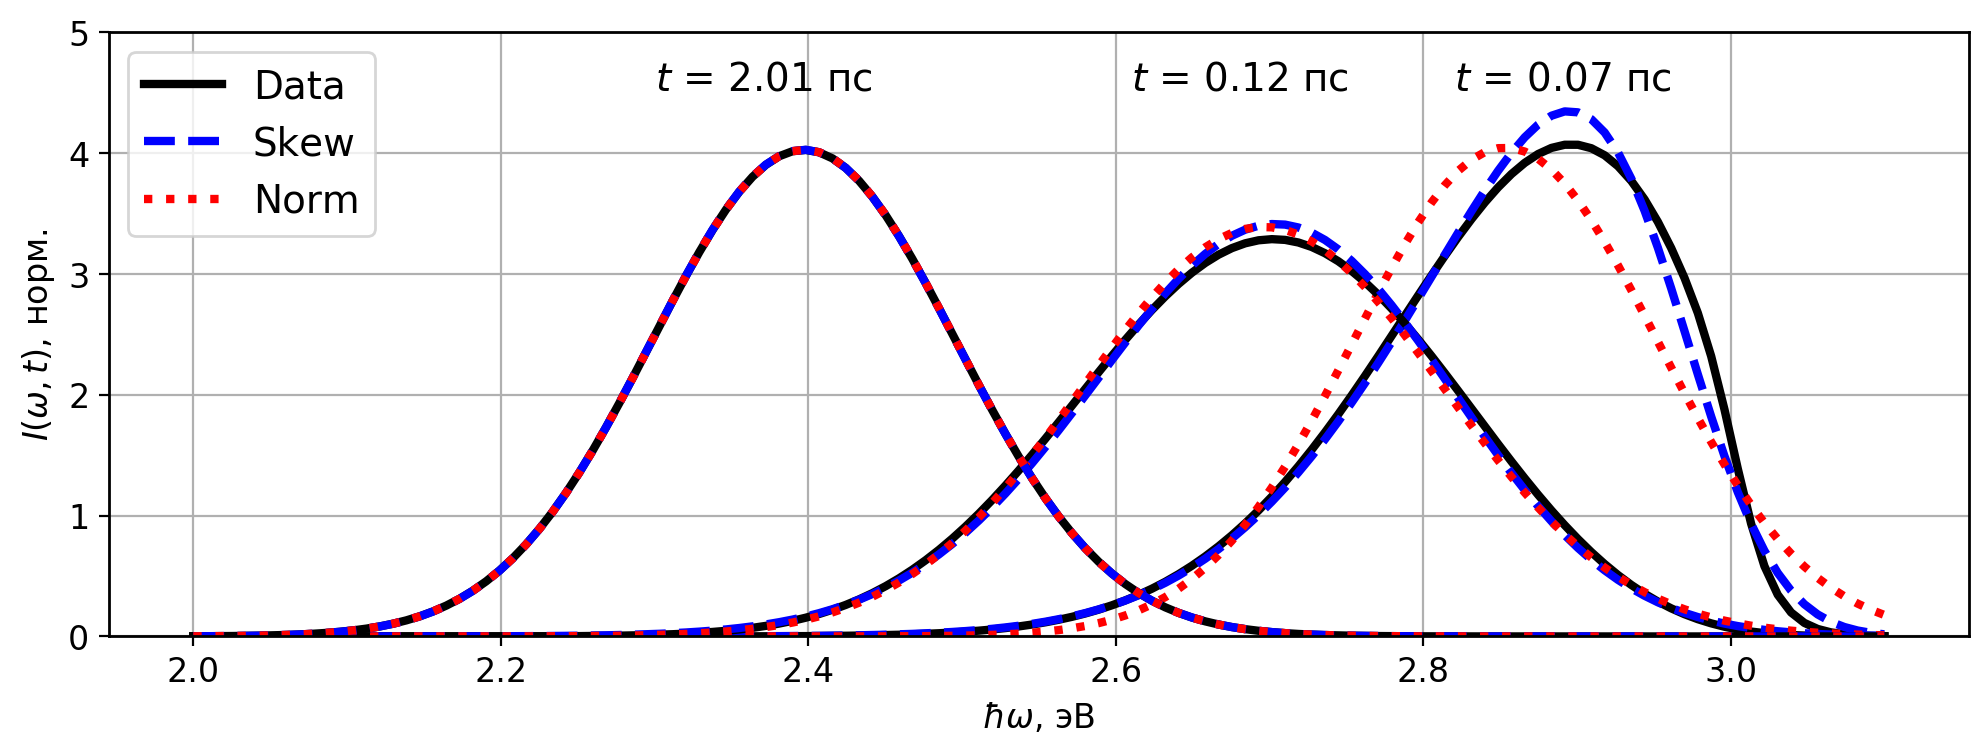

In [48]:
profile_plotter(3 , 2.82, 4.52, ['Data', 'Skew', 'Norm'])
profile_plotter(5 , 2.61, 4.52, ['', '', ''])
profile_plotter(85, 2.3, 4.52, ['', '', ''])
plt.ylabel('$I(\\omega,t)$, норм.')
plt.ylim(0,5)
plt.xlabel('$\\hbar\\omega$, эВ')
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig('spectra_skew_norm_vib.png')
plt.show()

In [38]:
S1 = np.zeros((len(Omspan),len(Tspan)))
for i in range(len(Tspan)):
    S1[:,i] = skewspec(Omspan, S0[:,i])
    #S1[:,i] = normspec(Omspan, S0[:,i])
    #S1[:,i] /= max(S1[:,i])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


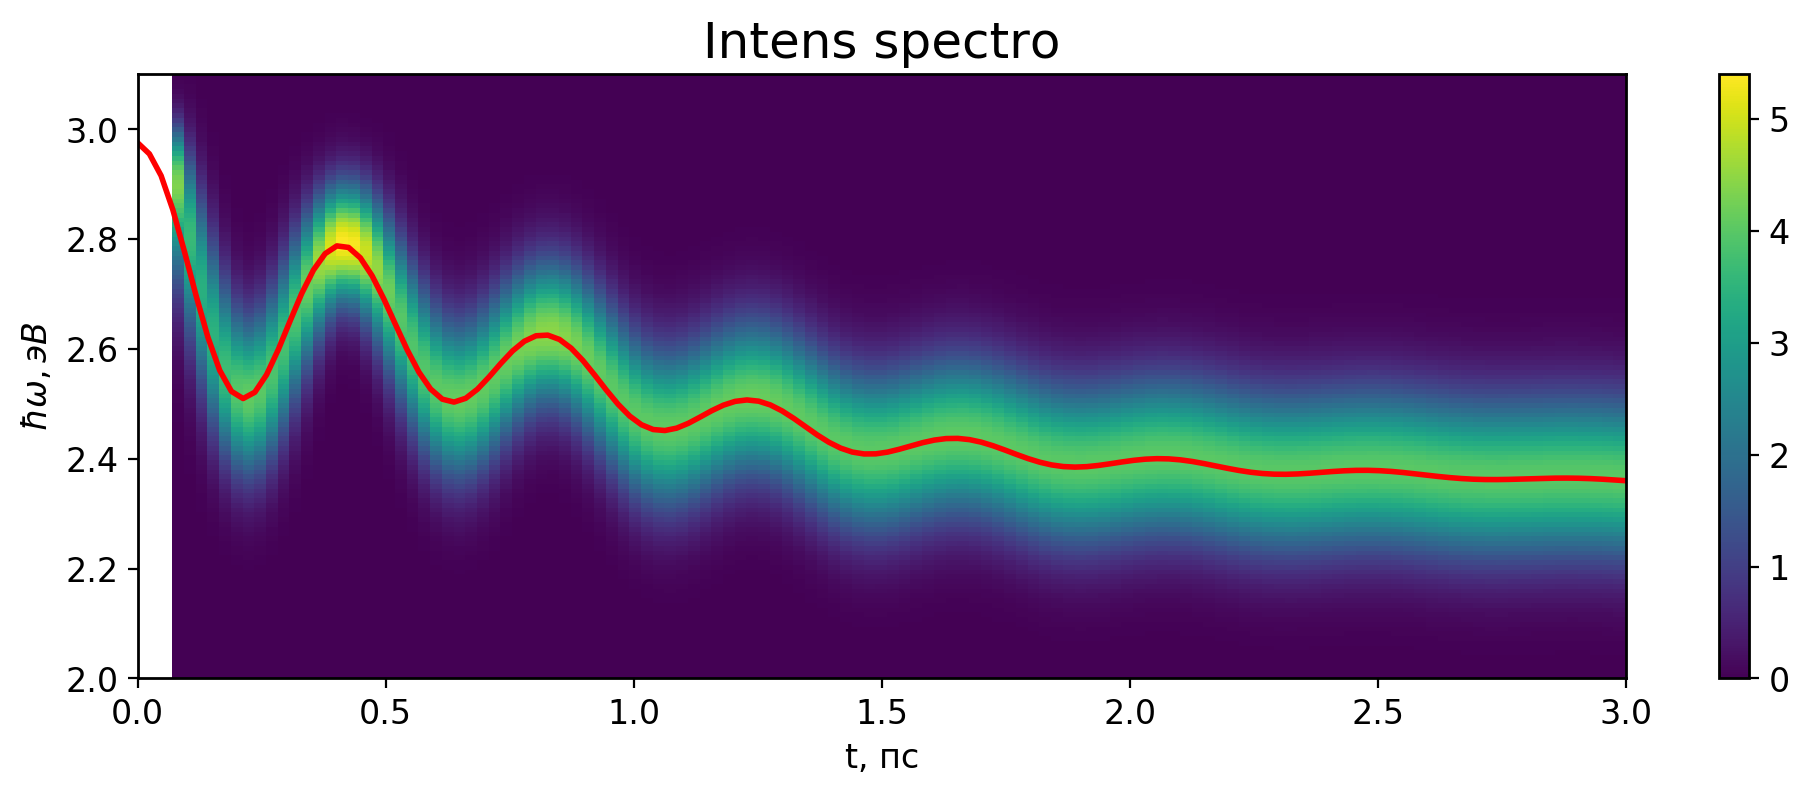

In [39]:
plt.pcolormesh(Tspan, Omspan, S1)
plt.colorbar()
plt.plot(Tspan, M1n, label = 'M1', color = 'red')
plt.title('Intens spectro')
plt.xlabel('t, пс')
plt.ylabel('$\\hbar\\omega, эВ$')
plt.show()

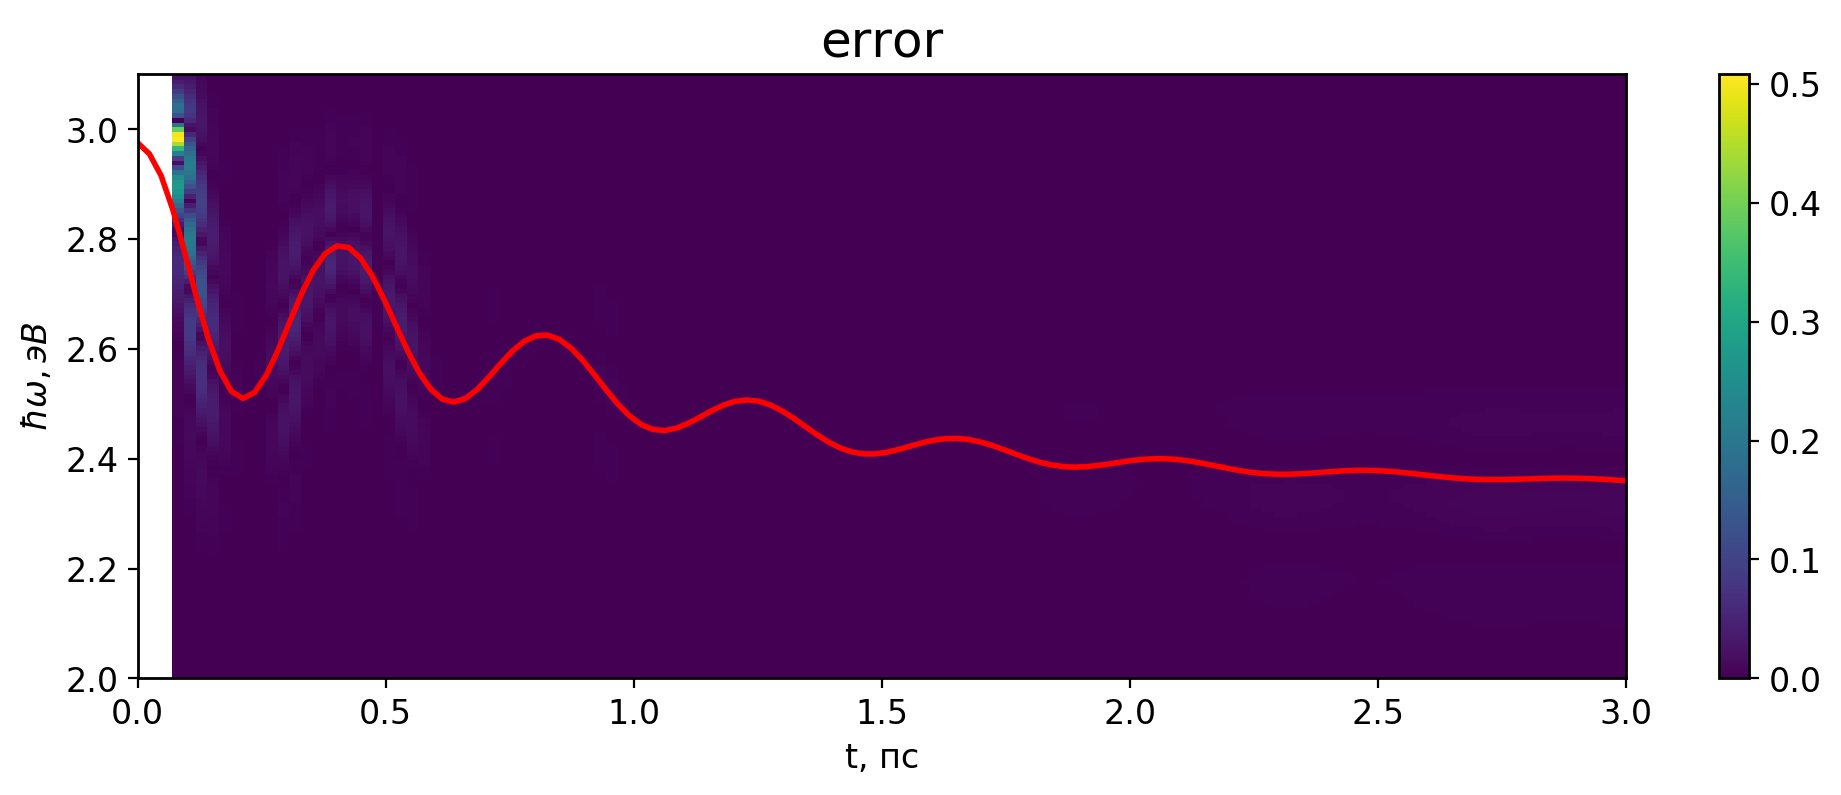

In [41]:
plt.pcolormesh(Tspan, Omspan, np.abs(S1-S0))
plt.colorbar()
plt.plot(Tspan, M1n, label = 'M1', color = 'red')
plt.title('error')
plt.xlabel('t, пс')
plt.ylabel('$\\hbar\\omega, эВ$')
plt.show()

In [53]:
def profile_plotter_dif(timenum, labs, ylab):
    y_values = skewspec(Omspan, S0[:,timenum])
    gaussian = normspec(Omspan, S0[:,timenum])
    plt.plot(Omspan, np.abs(S0[:,timenum]-y_values), linewidth=2, label=labs[0], color='blue')
    plt.plot(Omspan, np.abs(S0[:,timenum]-gaussian), linewidth=2, label=labs[1], color='red')
    plt.title(f'$t$ = {Tspan[timenum]:.2f} пс')
    plt.ylabel(ylab)
    plt.xlabel('$\\hbar\\omega$, эВ')
    plt.grid(True)
    plt.legend()

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


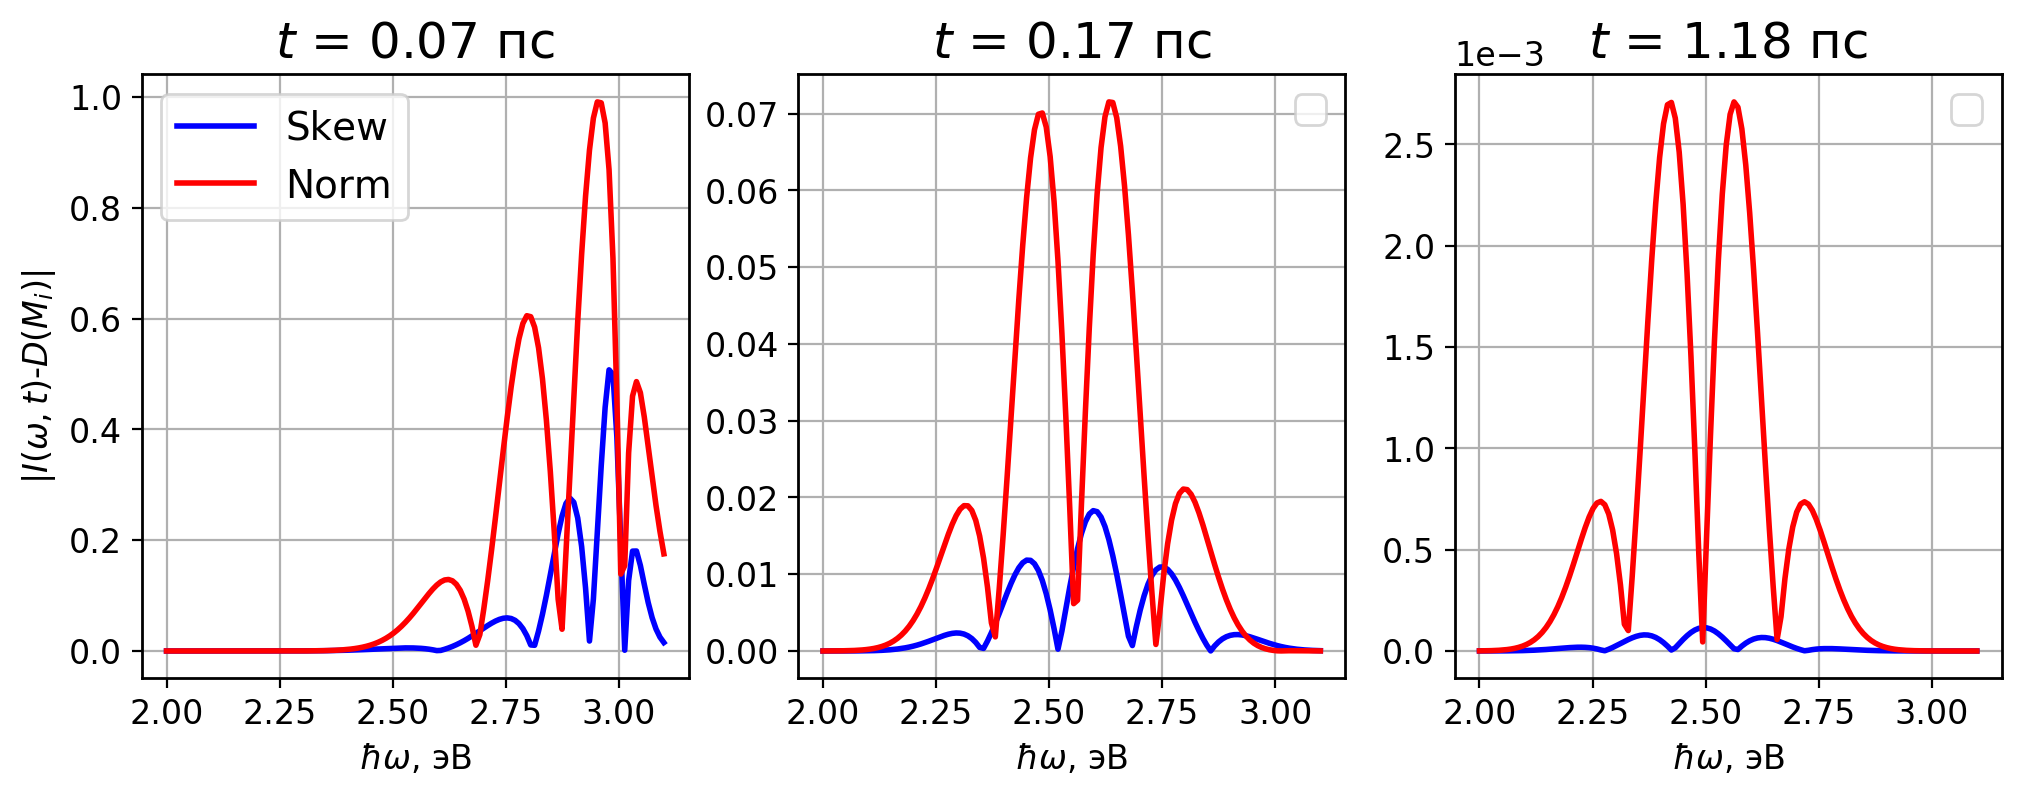

In [69]:
plt.subplot(131)
profile_plotter_dif( 3 , ['Skew', 'Norm'], '|$I(\\omega,t)$-$D(M_i)$|' )

plt.subplot(132)
profile_plotter_dif( 7 , ['', ''], "" )

plt.subplot(133)
profile_plotter_dif( 50 , ['', ''], "" )
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.savefig('spectra_dif_vib.png')
plt.show()

# W_3 = 0 (no vib)

In [70]:
S0 = np.zeros((len(Omspan),len(Tspan)))
start_time = time.time()  # Начало измерения времени  
for i in range(len(Omspan)):
    ss0 = calcdyn(Tspan, Omspan[i], dG=-2.5, Er=0.2, te=0.05, om_e=3.0, 
                  gam=2e-3, Om_r=1e-2, weights = [0.5, 0.5, 0.0] )
    for j in range(len(Tspan)):
        S0[i,j] = ss0[j]
end_time = time.time()  # Конец измерения времени  
print(f"run time: {end_time - start_time:.2f} seconds")  # Вывод времени в секундах 

run time: 102.96 seconds


In [71]:
for i in range(len(Tspan)):
    S0[:,i] /= np.trapz(S0[:,i], Omspan)
    #S0[:,i] /= max(S0[:,i])

In [72]:
M1n = [ np.sum(S0[:,i] * Omspan)/sum(S0[:,i]) for i in range(len(Tspan)) ];

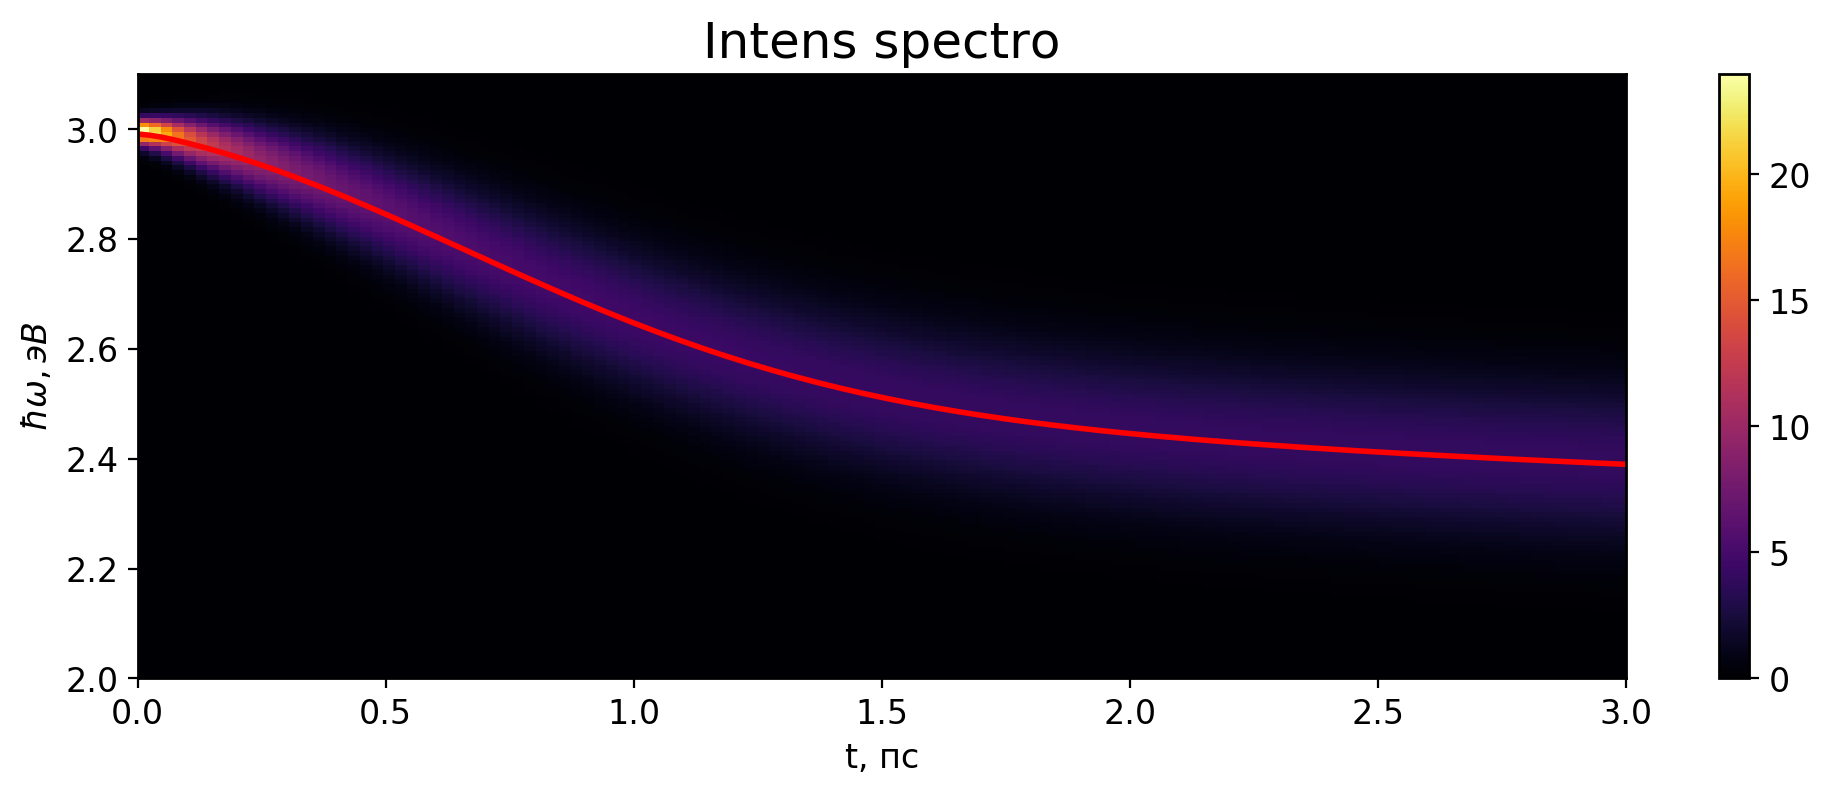

In [73]:
plt.pcolormesh(Tspan, Omspan, S0, cmap = 'inferno')
plt.colorbar()
plt.plot(Tspan, M1n, label = 'M1', color = 'red')
plt.title('Intens spectro')
plt.xlabel('t, пс')
plt.ylabel('$\\hbar\\omega, эВ$')
plt.show()

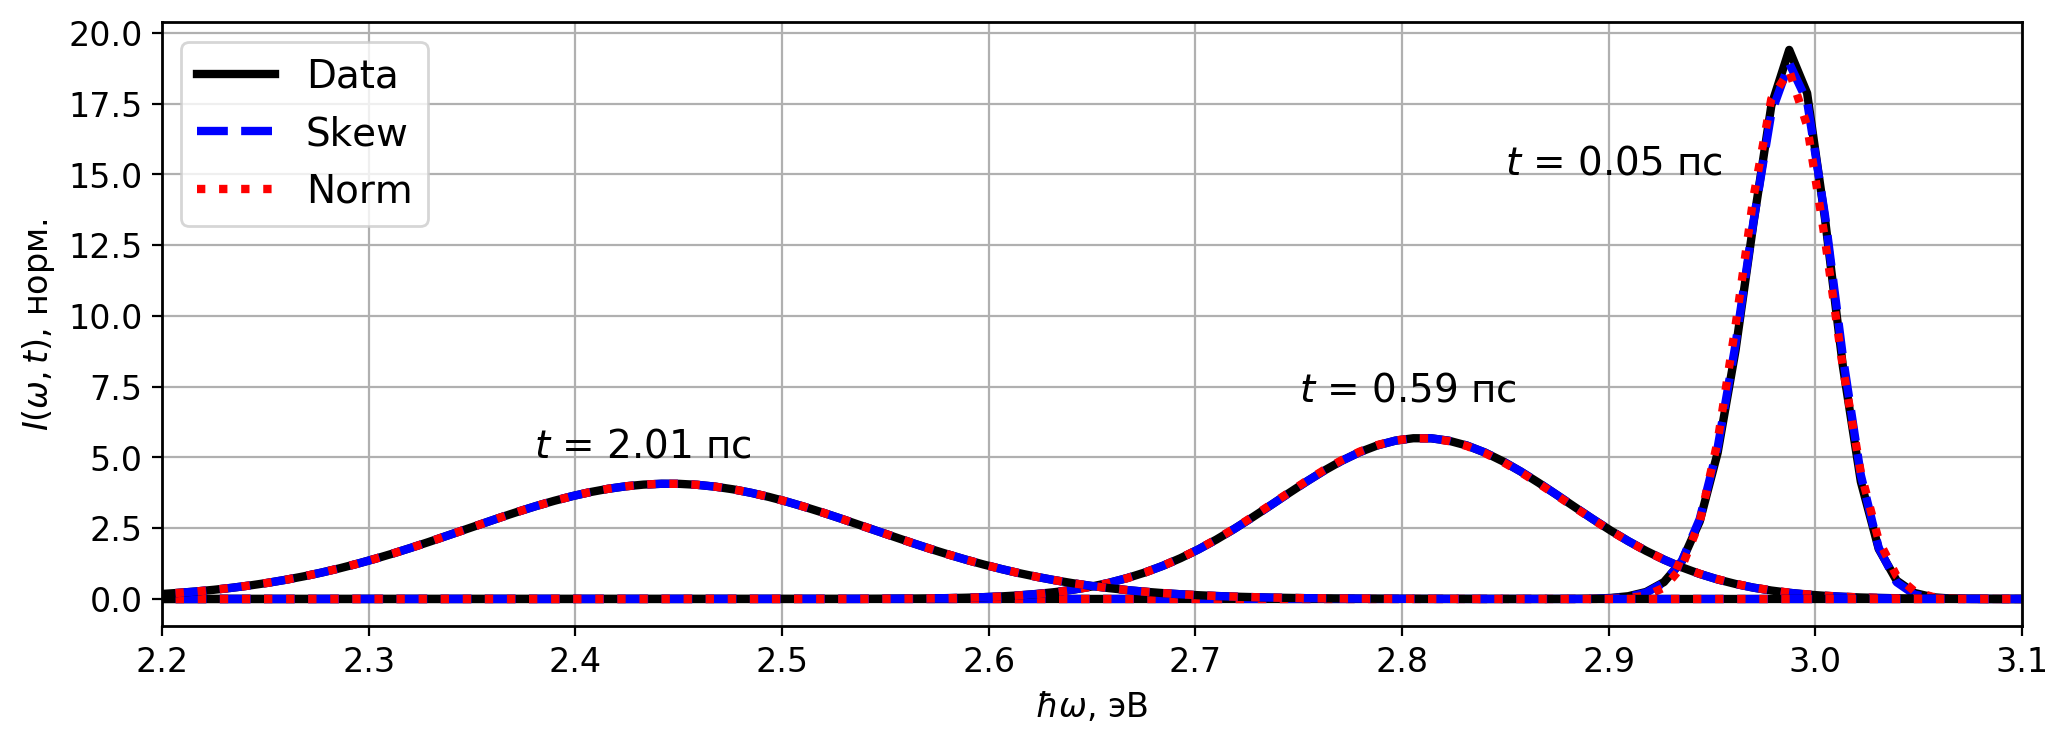

In [82]:
profile_plotter(2 , 2.85, 15.0, ['Data', 'Skew', 'Norm'])
profile_plotter(25 , 2.75, 7.0, ['', '', ''])
profile_plotter(85, 2.38, 5.0, ['', '', ''])
plt.ylabel('$I(\\omega,t)$, норм.')
plt.xlim(2.2,3.1)
plt.xlabel('$\\hbar\\omega$, эВ')
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig('spectra_skew_norm_novib.png')
plt.show()

In [75]:
S1 = np.zeros((len(Omspan),len(Tspan)))
for i in range(len(Tspan)):
    S1[:,i] = skewspec(Omspan, S0[:,i])
    #S1[:,i] /= max(S1[:,i])

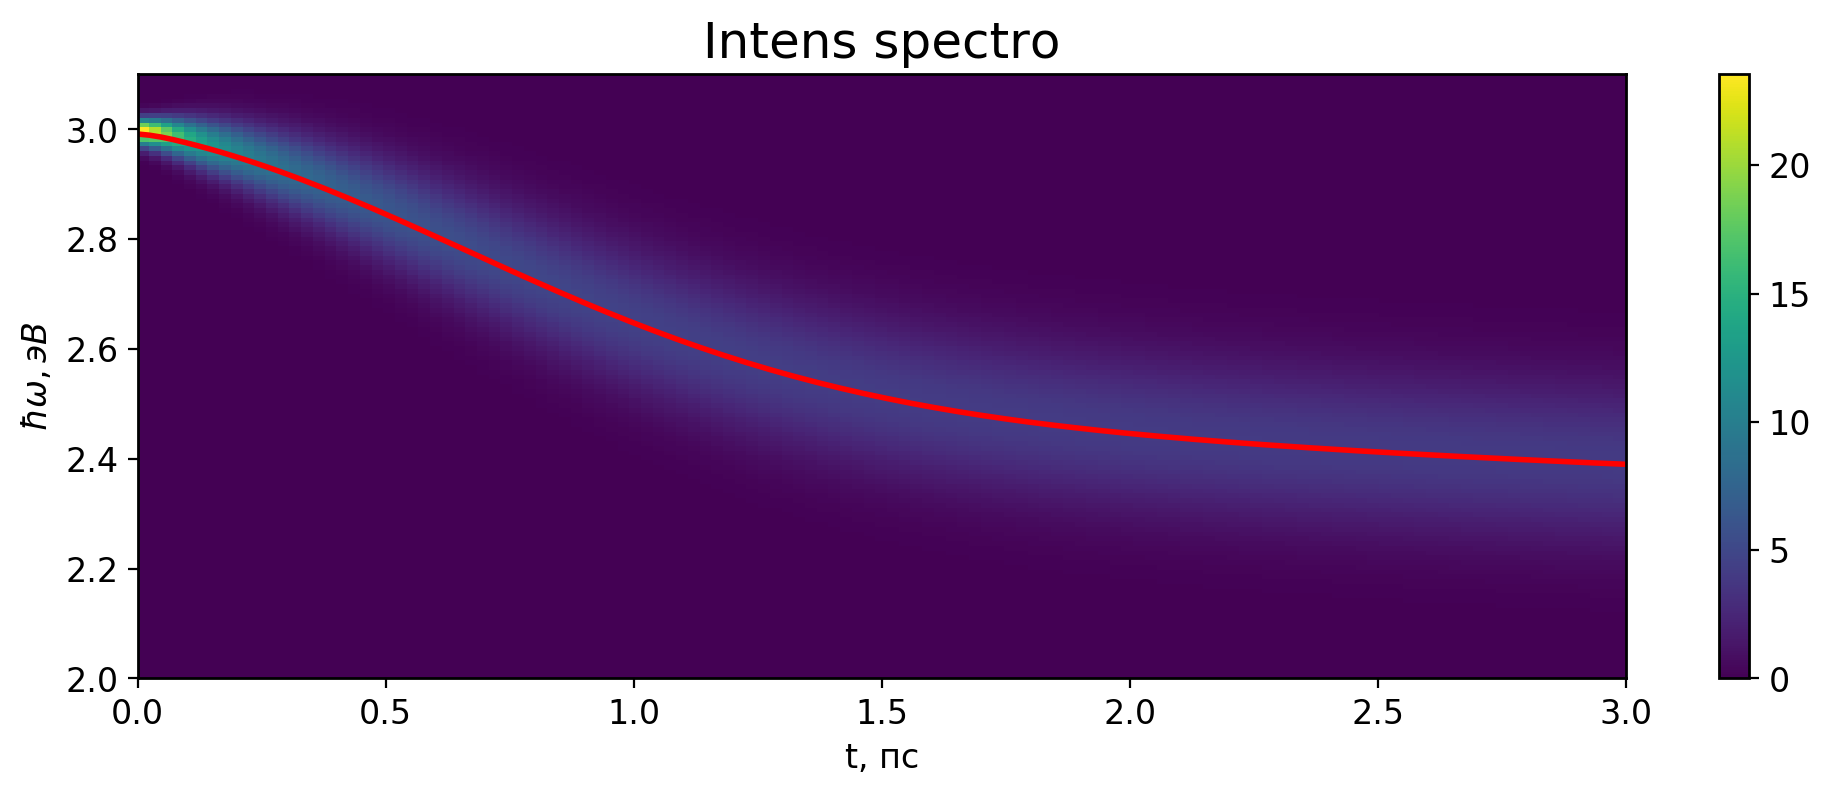

In [76]:
plt.pcolormesh(Tspan, Omspan, S1)
plt.colorbar()
plt.plot(Tspan, M1n, label = 'M1', color = 'red')
plt.title('Intens spectro')
plt.xlabel('t, пс')
plt.ylabel('$\\hbar\\omega, эВ$')
plt.show()

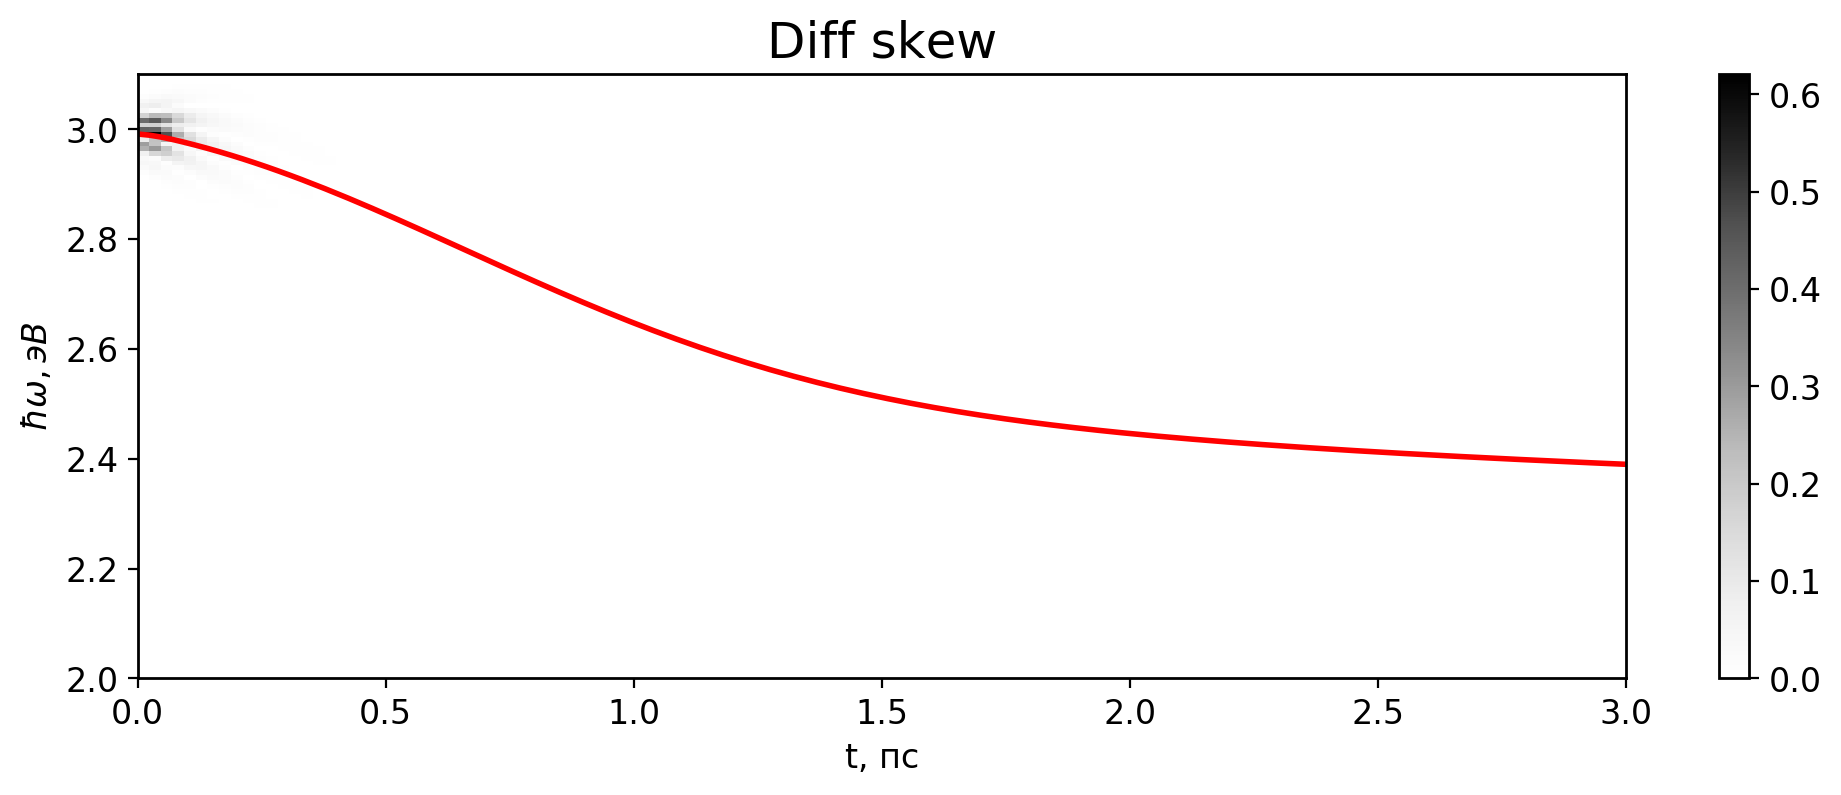

In [77]:
plt.pcolormesh(Tspan, Omspan, np.abs(S1-S0), cmap = 'Greys')
plt.colorbar()
plt.plot(Tspan, M1n, label = 'M1', color = 'red')
plt.title('Diff skew')
plt.xlabel('t, пс')
plt.ylabel('$\\hbar\\omega, эВ$')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


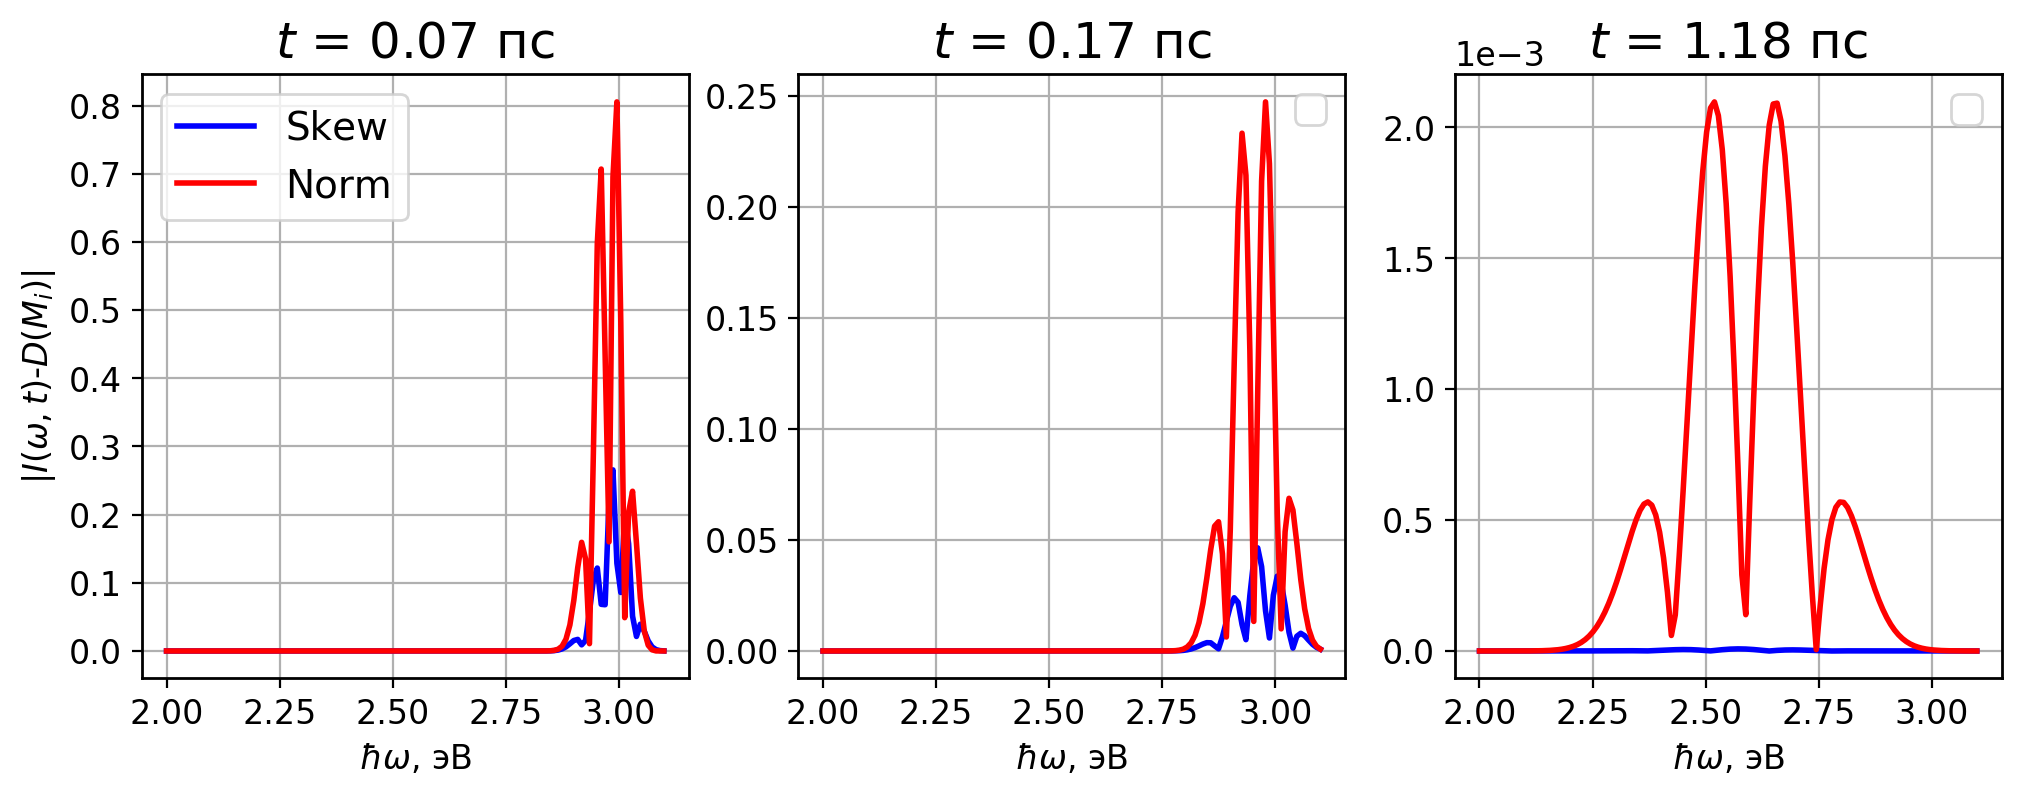

In [84]:
plt.subplot(131)
profile_plotter_dif( 3 , ['Skew', 'Norm'], '|$I(\\omega,t)$-$D(M_i)$|' )

plt.subplot(132)
profile_plotter_dif( 7 , ['', ''], "" )

plt.subplot(133)
profile_plotter_dif( 50 , ['', ''], "" )
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.savefig('spectra_dif_novib.png')
plt.show()